In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({
    "pgf.texsystem": "xelatex",
    'font.family': 'serif',
    'text.usetex': False,
    'pgf.rcfonts': False,
    'figure.dpi': 300,
})

import seaborn as sns
from tqdm import tqdm


# CHANNELS = ['cy5', 'TxRed', 'cy3', 'FAM']
CHANNELS = ['cy5', 'TxRed', 'FAM']
BASE_DIR = Path('../../../20251021_2dmouse_huanglab/')
RUN_ID = '20220918_PRISM_Brain_30plex_DAPI'

src_dir = BASE_DIR / f'{RUN_ID}_processed'
stc_dir = src_dir / 'stitched'
read_dir = src_dir / 'readout' / 'GMM'
figure_dir = read_dir / 'figures'
os.makedirs(read_dir, exist_ok=True)
os.makedirs(figure_dir, exist_ok=True)

# Load data and preprocess

In [2]:
GLAYER = 2
COLOR_GRADE = 5
Q_CHANNELS = ['Ye/A', 'B/A', 'R/A',]
# Q_NUM = int(COLOR_GRADE * (COLOR_GRADE + 1)/2)
Q_NUM = 15

# visualization
XRANGE = [-0.8, 0.8]
YRANGE = [-0.6, 0.8]

In [4]:
intensity_raw = pd.read_csv(read_dir / 'intensity_deduplicated.csv', index_col=0)
intensity = intensity_raw.copy()
intensity.head()

Y      X Channel     R    Ye  B  Scaled_R  Scaled_Ye  Scaled_B   sum  \
0  12853  20496     cy5  9201     0  0      9201          0         0  9201   
1  12851  20493     cy5  8971     0  0      8971          0         0  8971   
2  20807  28788     cy5  6253  1110  0      6253       1110         0  7363   
3  14156  30880     cy5  6148  1126  0      6148       1126         0  7274   
4  12652  30225     cy5  6132  1831  0      6132       1831         0  7963   

        R/A      Ye/A  B/A    X_coor   Y_coor  
0  1.000000  0.000000  0.0  0.707107 -0.57735  
1  1.000000  0.000000  0.0  0.707107 -0.57735  
2  0.849246  0.150754  0.0  0.493909 -0.57735  
3  0.845202  0.154798  0.0  0.488189 -0.57735  
4  0.770062  0.229938  0.0  0.381925 -0.57735

## Overview of data distribution

In [5]:
print("Available columns in intensity DataFrame:")
print(intensity.columns.tolist())

Available columns in intensity DataFrame:
['Y', 'X', 'Channel', 'R', 'Ye', 'B', 'Scaled_R', 'Scaled_Ye', 'Scaled_B', 'sum', 'R/A', 'Ye/A', 'B/A', 'X_coor', 'Y_coor']


In [6]:
data = intensity.copy()
# data = data.sample(10000)
fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(7,5))
ax[0].hist(bins=100, x=data['Ye/A'])
ax[1].hist(bins=100, x=data['B/A'])
ax[2].hist(bins=100, x=data['R/A'])
# ax[3].hist(bins=100, x=data['G/A'])

plt.savefig(figure_dir / 'histogram_raw.png', dpi=300, bbox_inches='tight')
plt.close()

## Gaussian blur and orthogonal decomposition

In [7]:
intensity['sum'] = intensity['Scaled_R'] + intensity['Scaled_Ye'] + intensity['Scaled_B']
intensity['Ye/A'] = intensity['Scaled_Ye'] / intensity['sum']
intensity['B/A'] = intensity['Scaled_B'] / intensity['sum']
intensity['R/A'] = intensity['Scaled_R'] / intensity['sum']
# intensity['G/A'] = intensity['Scaled_G'] / intensity['sum']

# adjust of G_channel
# intensity['G/A'] = np.log(1 + intensity['G/A']) / np.log(10)
# intensity['G/A'] = np.log1p(intensity['G/A'])
# intensity['G/A'] = intensity['G/A'] * np.exp(0.8 * intensity['Ye/A'])


RYB_x_transform = np.array([[-np.sqrt(2)/2], [np.sqrt(2)/2], [0]])
RYB_y_transform = np.array([[-1/2], [-1/2], [np.sqrt(2)/2]])
RYB_xy_transform = np.concatenate([RYB_x_transform, RYB_y_transform], axis=1)
intensity['X_coor'] = intensity[Q_CHANNELS] @ RYB_x_transform
intensity['Y_coor'] = intensity[Q_CHANNELS] @ RYB_y_transform

In [8]:
# # blur at position 0
# gaussian = np.concatenate([np.random.normal(loc=0, scale=0.01, size=intensity[Q_CHANNELS].shape), 
#                            np.random.normal(loc=0, scale=0.01, size=intensity[['G/A']].shape)], axis=1)
# intensity[Q_CHANNELS + ['G/A']] = intensity[Q_CHANNELS + ['G/A']].mask(intensity[Q_CHANNELS + ['G/A']]==0, gaussian)

# # blur at position 1
# gaussian = np.random.normal(loc=0, scale=0.01, size=intensity[Q_CHANNELS].shape)
# intensity[Q_CHANNELS] = intensity[Q_CHANNELS].mask(intensity[Q_CHANNELS]==1, 1 + gaussian)

# intensity['X_coor_gaussian'] = intensity[Q_CHANNELS] @ RYB_x_transform
# intensity['Y_coor_gaussian'] = intensity[Q_CHANNELS] @ RYB_y_transform

# 高斯模糊处理
gaussian = np.random.normal(loc=0, scale=0.01, size=intensity[Q_CHANNELS].shape)
intensity[Q_CHANNELS] = intensity[Q_CHANNELS].mask(intensity[Q_CHANNELS]==0, gaussian)
intensity[Q_CHANNELS] = intensity[Q_CHANNELS].mask(intensity[Q_CHANNELS]==1, 1 + gaussian)
intensity['X_coor_gaussian'] = intensity[Q_CHANNELS] @ RYB_x_transform
intensity['Y_coor_gaussian'] = intensity[Q_CHANNELS] @ RYB_y_transform

## Overview of preprocessed data distribution

In [9]:
from scipy.signal import argrelextrema


def plot_hist_with_extrema(a, ax=None, bins=100, extrema='max', kde_kws={'bw_adjust':0.5}):
    sns.histplot(a, bins=bins, stat='count', edgecolor='white', alpha=1, ax=ax, kde=True, kde_kws=kde_kws)
    y = ax.get_lines()[0].get_ydata()
    if extrema == 'max':
        y = -y
    extrema = [float(_/len(y)*(max(a)-min(a))+min(a)) for _ in argrelextrema(np.array(y), np.less)[0]]
    for subextrema in extrema:
        ax.axvline(x=subextrema, color='r', alpha=0.5, linestyle='--')
    return extrema

# data = intensity.copy()
data = intensity.sample(200000)
fig, ax = plt.subplots(ncols=1, nrows=4, figsize=(7, 7))
plt.setp(ax, xlim=(-0.25, 1.2))
Y_maxima = plot_hist_with_extrema(data['Ye/A'], ax=ax[0], extrema='max', kde_kws={'bw_adjust':1.6})
B_maxima = plot_hist_with_extrema(data['B/A'], ax=ax[1], extrema='max', kde_kws={'bw_adjust':1})
R_maxima = plot_hist_with_extrema(data['R/A'], ax=ax[2], extrema='max', kde_kws={'bw_adjust':1})
# G_minima = plot_hist_with_extrema(data['G/A'], ax=ax[3], extrema='min', kde_kws={'bw_adjust':2})

if len(Y_maxima) != COLOR_GRADE: Y_maxima = [(_) / (COLOR_GRADE-1) for _ in range(COLOR_GRADE)]
if len(B_maxima) != COLOR_GRADE: B_maxima = [(_) / (COLOR_GRADE-1) for _ in range(COLOR_GRADE)]
if len(R_maxima) != COLOR_GRADE: R_maxima = [(_) / (COLOR_GRADE-1) for _ in range(COLOR_GRADE)]

plt.savefig(figure_dir / 'histogram.png', dpi=300, bbox_inches='tight')
plt.close()

In [10]:
# minima = G_minima.copy()
# minima = minima[: GLAYER - 1]
# minima.insert(0, intensity['G/A'].min()-0.01)
# minima.append(intensity['G/A'].max()+0.01)

# intensity['G_layer'] = pd.cut(intensity['G/A'], bins=minima, labels=[_ for _ in range(len(minima)-1)], include_lowest=True, right=False)

# gap_l = 0
# gap_r = 0
# for division in minima[1: GLAYER]: intensity = intensity[(intensity['G/A']<division-gap_l)|(intensity['G/A']>division+gap_r)]

# 设置G信号默认为0
intensity['G/A'] = 0  # 所有数据点的G通道设为0

# 移除分层处理代码，直接设置所有数据为第0层
GLAYER = 1  # 只有一层
intensity['G_layer'] = 0  # 所有数据点都属于第0层

In [11]:
# def ybrg_to_rgb(ybr, g=0):
#     y, b, r = ybr
#     red = y + r
#     green = 0.9 * y + 0.2 * g
#     blue = b
#     return ((red, green, blue) / np.max((red, green, blue))).clip(0, 1)

# def reorder(array, order='PRISM30'):
#     if order == 'PRISM30':
#         relabel = {1:1, 2:6, 3:10, 4:13, 5:15, 6:14, 7:12, 8:9, 9:5, 10:4, 11:3, 12:2, 13:7, 14:11, 15:8}
#     elif order == 'PRISM63':
#         relabel = {1:1, 2:7, 3:12, 4:16, 5:19, 6:21, 7:20, 8:18, 9:15, 10:11, 11:6, 
#                      12:5, 13:4, 14:3, 15:2, 16:8, 17:13, 18:9, 19:17, 20:14, 21:10}
#     else:print('Undefined order, use PRISM30 or PRISM63 instead.')
#     return np.array([array[relabel[_]-1] for _ in relabel])
def ybr_to_rgb(ybr):
    y, b, r = ybr
    rgb = np.array([y + r, 0.9 * y, b])
    return (rgb / np.max(rgb)).clip(0, 1) if np.max(rgb) > 0 else rgb

def reorder(array, order='PRISM15'):
    prism15 = {
        1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8, 9:9, 10:10, 11:11, 12:12, 13:13, 14:14, 15:15}
    mapping = {
        'PRISM15': prism15}.get(order, prism15)  # 默认使用PRISM15
    return np.array([array[mapping[_]-1] for _ in mapping])


NameError: name 'itertools' is not defined

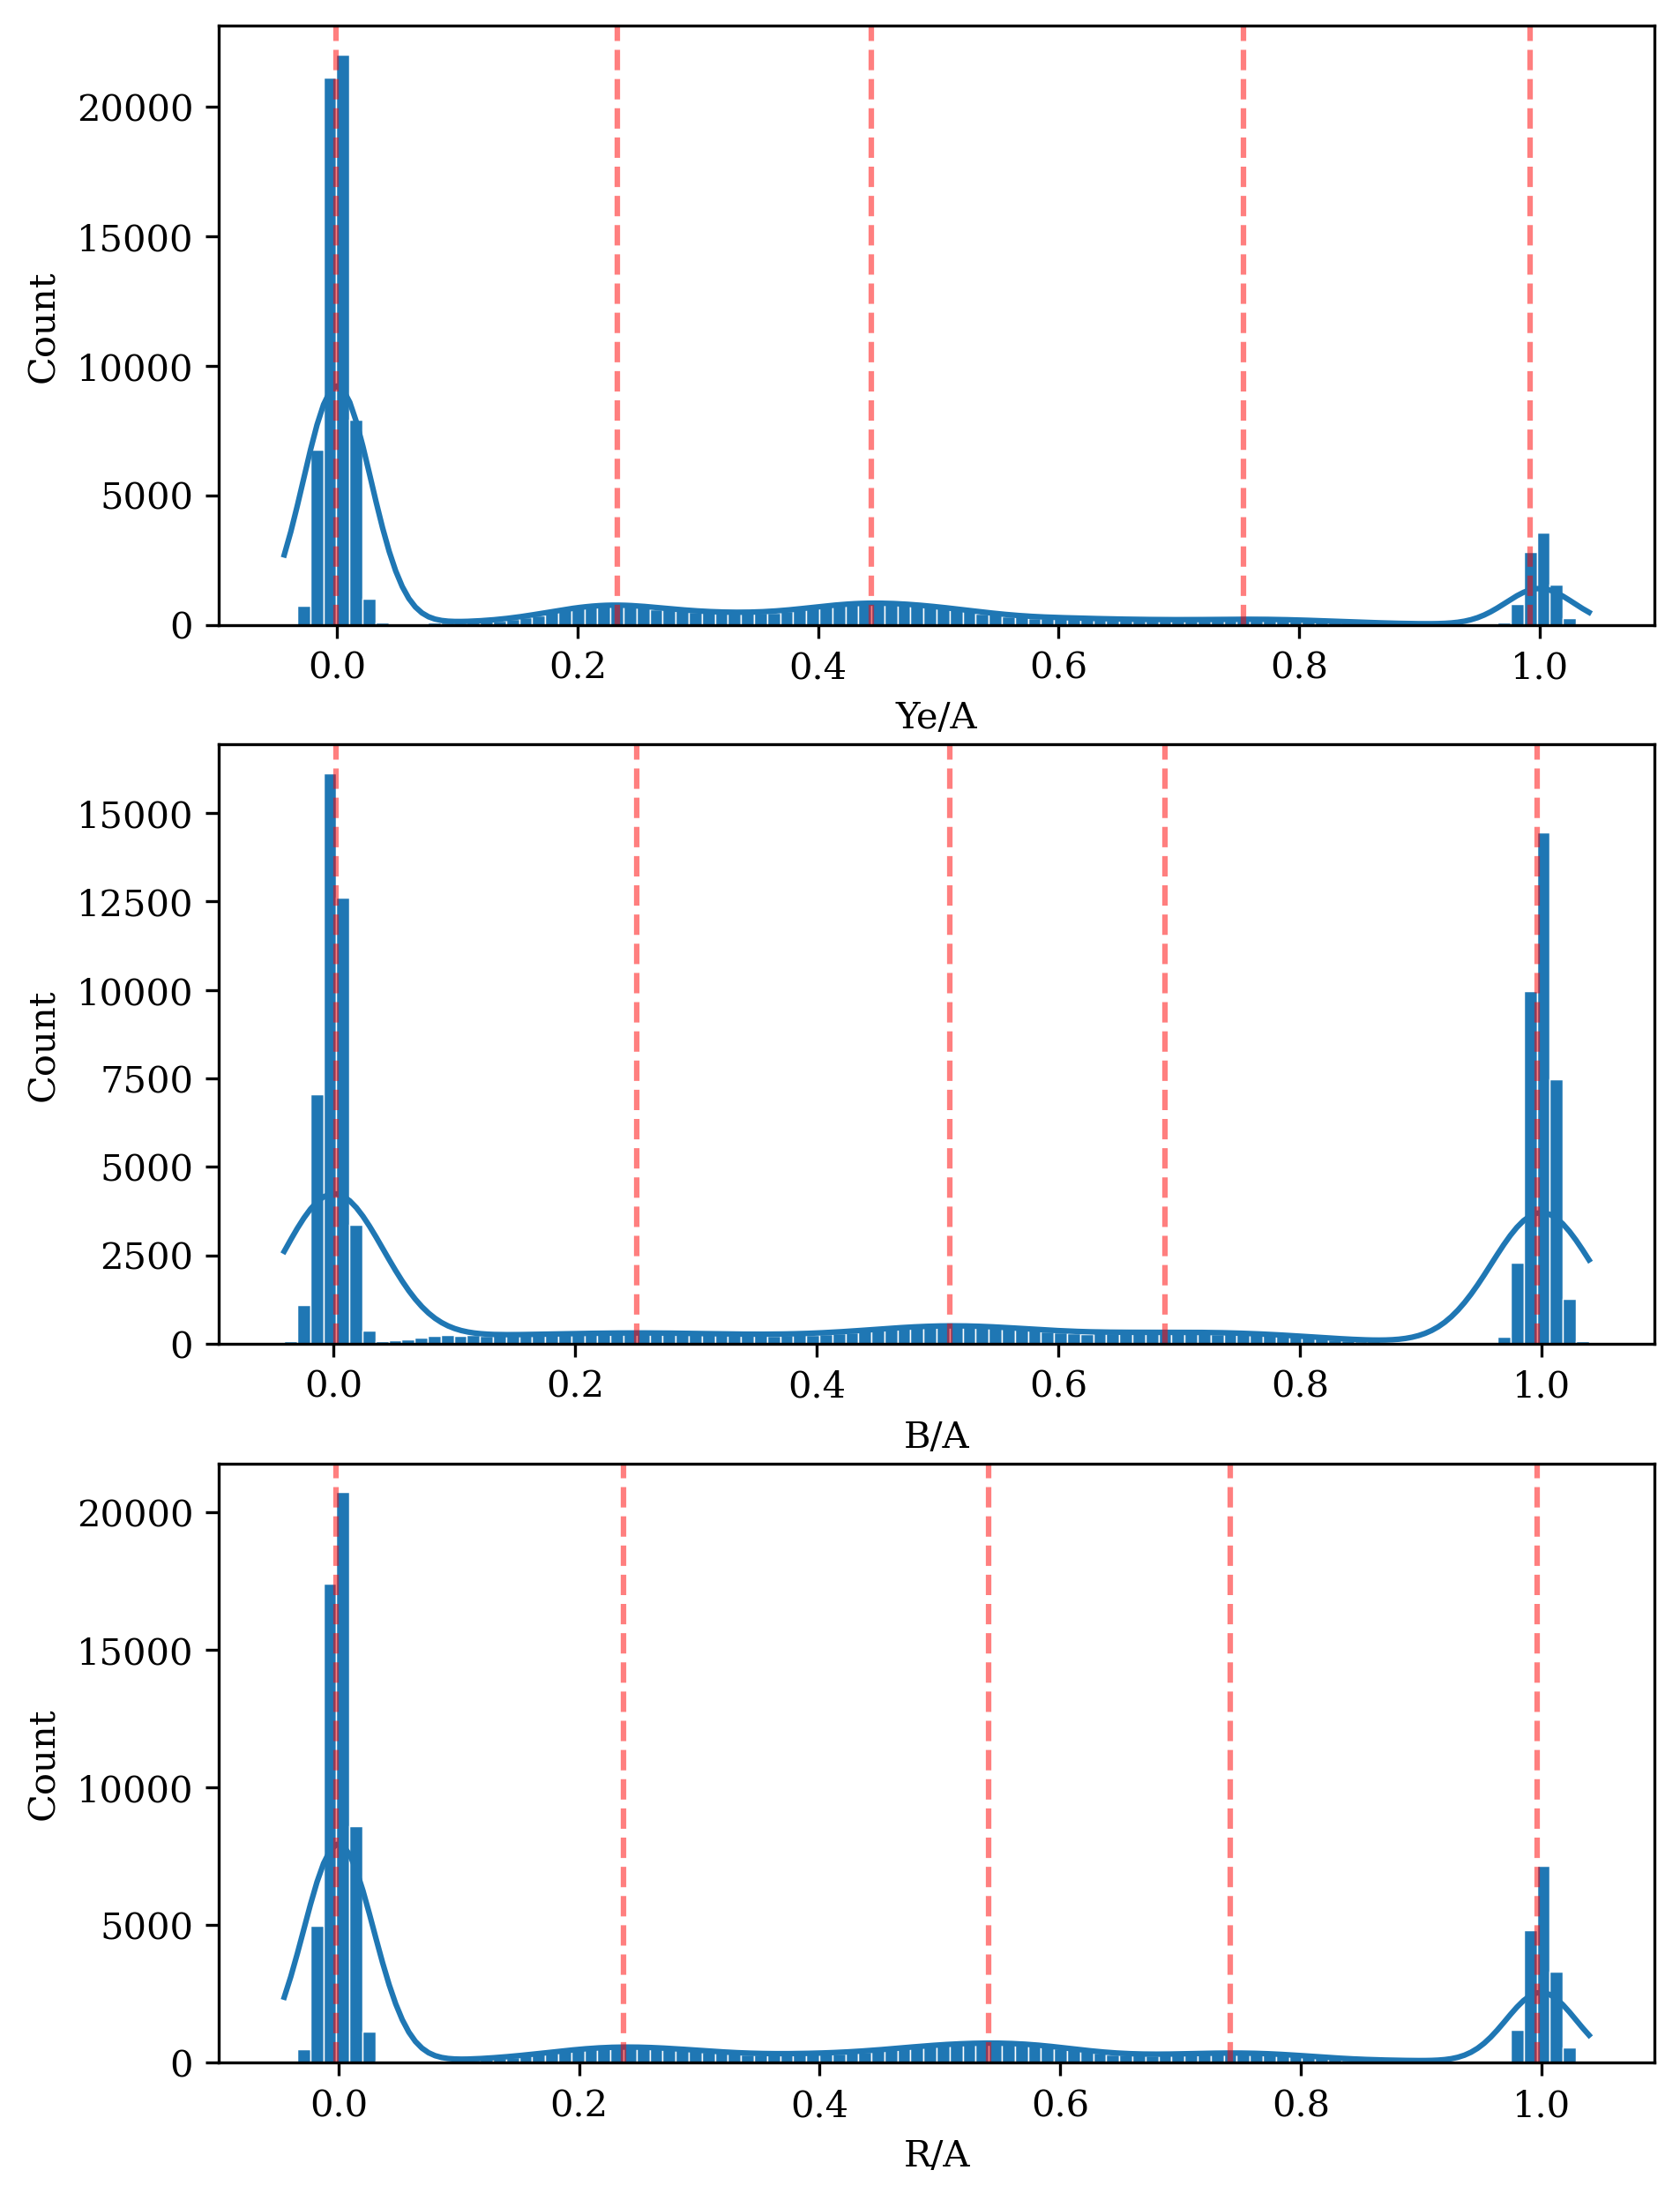

In [12]:
# # preparation for init centroids
# import itertools

# centroid_init_dict = dict()
# colormap = dict()

# fig, ax =  plt.subplots(nrows=3, ncols=GLAYER, figsize=(20, 10))
# for layer in range(GLAYER):
#     data = intensity[intensity['G_layer'] == layer]
#     data = data.sample(min(100000, len(data)))
#     ax_tmp = ax if GLAYER < 2 else ax[:, layer]
#     ax_tmp[0].set_title(f'G_layer{layer}')
#     Y_maxima_tmp = plot_hist_with_extrema(data['Ye/A'], ax=ax_tmp[0], extrema='max', kde_kws={'bw_adjust':0.8})
#     B_maxima_tmp = plot_hist_with_extrema(data['B/A'], ax=ax_tmp[1], extrema='max', kde_kws={'bw_adjust':0.9})
#     R_maxima_tmp = plot_hist_with_extrema(data['R/A'], ax=ax_tmp[2], extrema='max', kde_kws={'bw_adjust':0.7})

#     if len(R_maxima_tmp) != COLOR_GRADE: R_maxima_tmp = R_maxima
#     if len(Y_maxima_tmp) != COLOR_GRADE: Y_maxima_tmp = Y_maxima
#     if len(B_maxima_tmp) != COLOR_GRADE: B_maxima_tmp = B_maxima

#     combinations = itertools.product(range(0, COLOR_GRADE), repeat=3)
#     filtered_combinations = filter(lambda x: sum(x) == COLOR_GRADE - 1, combinations)
#     centroid_init_dict[layer] = np.array([[Y_maxima_tmp[_[0]], B_maxima_tmp[_[1]], R_maxima_tmp[_[2]],] for _ in filtered_combinations])
#     centroid_init_dict[layer] = reorder(centroid_init_dict[layer], order='PRISM30')
#     color_list = [ybrg_to_rgb(_, g=layer/GLAYER) for _ in centroid_init_dict[layer]]
#     colormap[layer] = {layer*Q_NUM + i + 1:color_list[i] for i in range(len(color_list))}

# plt.savefig(figure_dir / 'histogram_by_layer.png', dpi=300, bbox_inches='tight')
# plt.close()

# 设置单层处理
GLAYER = 1
intensity['G_layer'] = 0  # 所有数据点都属于第0层

# 初始化字典
centroid_init_dict = {}
colormap = {}

# 创建绘图（简化版）
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(7, 10))

# 仅处理第0层
layer = 0
data = intensity.sample(min(100000, len(intensity)))  # 使用所有数据

# 绘制直方图并获取极值点
Y_maxima_tmp = plot_hist_with_extrema(data['Ye/A'], ax=ax[0], extrema='max', kde_kws={'bw_adjust':0.8})
B_maxima_tmp = plot_hist_with_extrema(data['B/A'], ax=ax[1], extrema='max', kde_kws={'bw_adjust':0.9})
R_maxima_tmp = plot_hist_with_extrema(data['R/A'], ax=ax[2], extrema='max', kde_kws={'bw_adjust':0.7})

# 确保有足够的极值点
if len(R_maxima_tmp) != COLOR_GRADE: R_maxima_tmp = [i/(COLOR_GRADE-1) for i in range(COLOR_GRADE)]
if len(Y_maxima_tmp) != COLOR_GRADE: Y_maxima_tmp = [i/(COLOR_GRADE-1) for i in range(COLOR_GRADE)]
if len(B_maxima_tmp) != COLOR_GRADE: B_maxima_tmp = [i/(COLOR_GRADE-1) for i in range(COLOR_GRADE)]

# 生成聚类中心
combinations = itertools.product(range(0, COLOR_GRADE), repeat=3)
filtered_combinations = filter(lambda x: sum(x) == COLOR_GRADE - 1, combinations)
centroid_init_dict[layer] = np.array([[Y_maxima_tmp[_[0]], B_maxima_tmp[_[1]], R_maxima_tmp[_[2]]] 
                                     for _ in filtered_combinations])

# 重排序聚类中心
centroid_init_dict[layer] = reorder(centroid_init_dict[layer], order='PRISM15')

# 生成颜色映射（使用修改后的ybr_to_rgb函数）
color_list = [ybr_to_rgb(_) for _ in centroid_init_dict[layer]]
colormap = {i + 1: color_list[i] for i in range(len(color_list))}

# 保存并关闭图表
plt.savefig(figure_dir / 'histogram.png', dpi=300, bbox_inches='tight')
plt.close()

In [12]:
# s = 0.01
# alpha = 0.05
# percentile_thre = 99.5
# bins = (500, 500)

# n_rows = 2
# n_cols = 2 + GLAYER
# fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5 * n_cols + 2, 10))
# ax[1,0].scatter(intensity['X_coor_gaussian'], intensity['G/A'], s=s, alpha=alpha, linewidths=None)
# ax[1,0].set_ylim([-0.2,1.4])
# ax[0,1].scatter(intensity['Y_coor_gaussian'], intensity['G/A'], s=s, alpha=alpha, linewidths=None)
# ax[0,1].set_ylim([-0.2,1.4])
# ax[0,0].scatter(intensity['X_coor_gaussian'], intensity['Y_coor_gaussian'], s=s, alpha=alpha, linewidths=None)
# ax[0,0].set_xlim(XRANGE)
# ax[0,0].set_ylim(YRANGE)


# for subextrema in minima: ax[1,0].axhline(y=subextrema, color='r', alpha=0.5, linestyle='--')
# for subextrema in minima: ax[0,1].axhline(y=subextrema, color='r', alpha=0.5, linestyle='--')

# for layer in range(GLAYER):
#     ax_scatter = ax[0, 2+layer]
#     ax_hist = ax[1, 2+layer]
#     sub = intensity[(intensity['sum']>1000)&(intensity['sum']<15000)&(intensity['G_layer']==layer)]
#     ax_scatter.set_title(f'G={layer}')
#     ax_scatter.scatter(sub['X_coor_gaussian'], sub['Y_coor_gaussian'], s=s, alpha=alpha, linewidths=None)
#     ax_scatter.set_xlim(XRANGE)
#     ax_scatter.set_ylim(YRANGE)

#     x, y = sub['X_coor_gaussian'], sub['Y_coor_gaussian']
#     hist, xedges, yedges = np.histogram2d(x, y, bins=bins)
#     percentile = np.percentile(hist, percentile_thre)
#     ax_hist.hist2d(x, y, bins=bins, vmax=percentile,
#                    range=[XRANGE, YRANGE], cmap='inferno')
#     ax_hist.set_xlim(XRANGE)
#     ax_hist.set_ylim(YRANGE)
    
# plt.savefig(figure_dir / 'ColorSpace_overview.png', dpi=300, bbox_inches='tight')
# plt.close()
s = 0.01
alpha = 0.05
percentile_thre = 99.5
bins = (500, 500)

# 简化布局 - 单层处理
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

# 二维散点图
ax[0, 0].scatter(intensity['X_coor_gaussian'], intensity['Y_coor_gaussian'], 
                s=s, alpha=alpha, linewidths=None)
ax[0, 0].set_xlim(XRANGE)
ax[0, 0].set_ylim(YRANGE)
ax[0, 0].set_title('2D Scatter Plot')

# 二维密度图
x, y = intensity['X_coor_gaussian'], intensity['Y_coor_gaussian']
hist, xedges, yedges = np.histogram2d(x, y, bins=bins)
percentile = np.percentile(hist, percentile_thre)
ax[0, 1].hist2d(x, y, bins=bins, vmax=percentile,
               range=[XRANGE, YRANGE], cmap='inferno')
ax[0, 1].set_xlim(XRANGE)
ax[0, 1].set_ylim(YRANGE)
ax[0, 1].set_title('Density Distribution')

# 筛选高质量点
sub = intensity[(intensity['sum'] > 1000) & (intensity['sum'] < 15000)]

# 高质量点散点图
ax[1, 0].scatter(sub['X_coor_gaussian'], sub['Y_coor_gaussian'], 
                s=s, alpha=alpha, linewidths=None)
ax[1, 0].set_xlim(XRANGE)
ax[1, 0].set_ylim(YRANGE)
ax[1, 0].set_title('High Quality Points')

# 高质量点密度图
x_sub, y_sub = sub['X_coor_gaussian'], sub['Y_coor_gaussian']
hist_sub, _, _ = np.histogram2d(x_sub, y_sub, bins=bins)
percentile_sub = np.percentile(hist_sub, percentile_thre)
ax[1, 1].hist2d(x_sub, y_sub, bins=bins, vmax=percentile_sub,
               range=[XRANGE, YRANGE], cmap='inferno')
ax[1, 1].set_xlim(XRANGE)
ax[1, 1].set_ylim(YRANGE)
ax[1, 1].set_title('High Quality Density')

plt.tight_layout()
plt.savefig(figure_dir / 'ColorSpace_overview.png', dpi=300, bbox_inches='tight')
plt.close()

## Projection of density in 3D

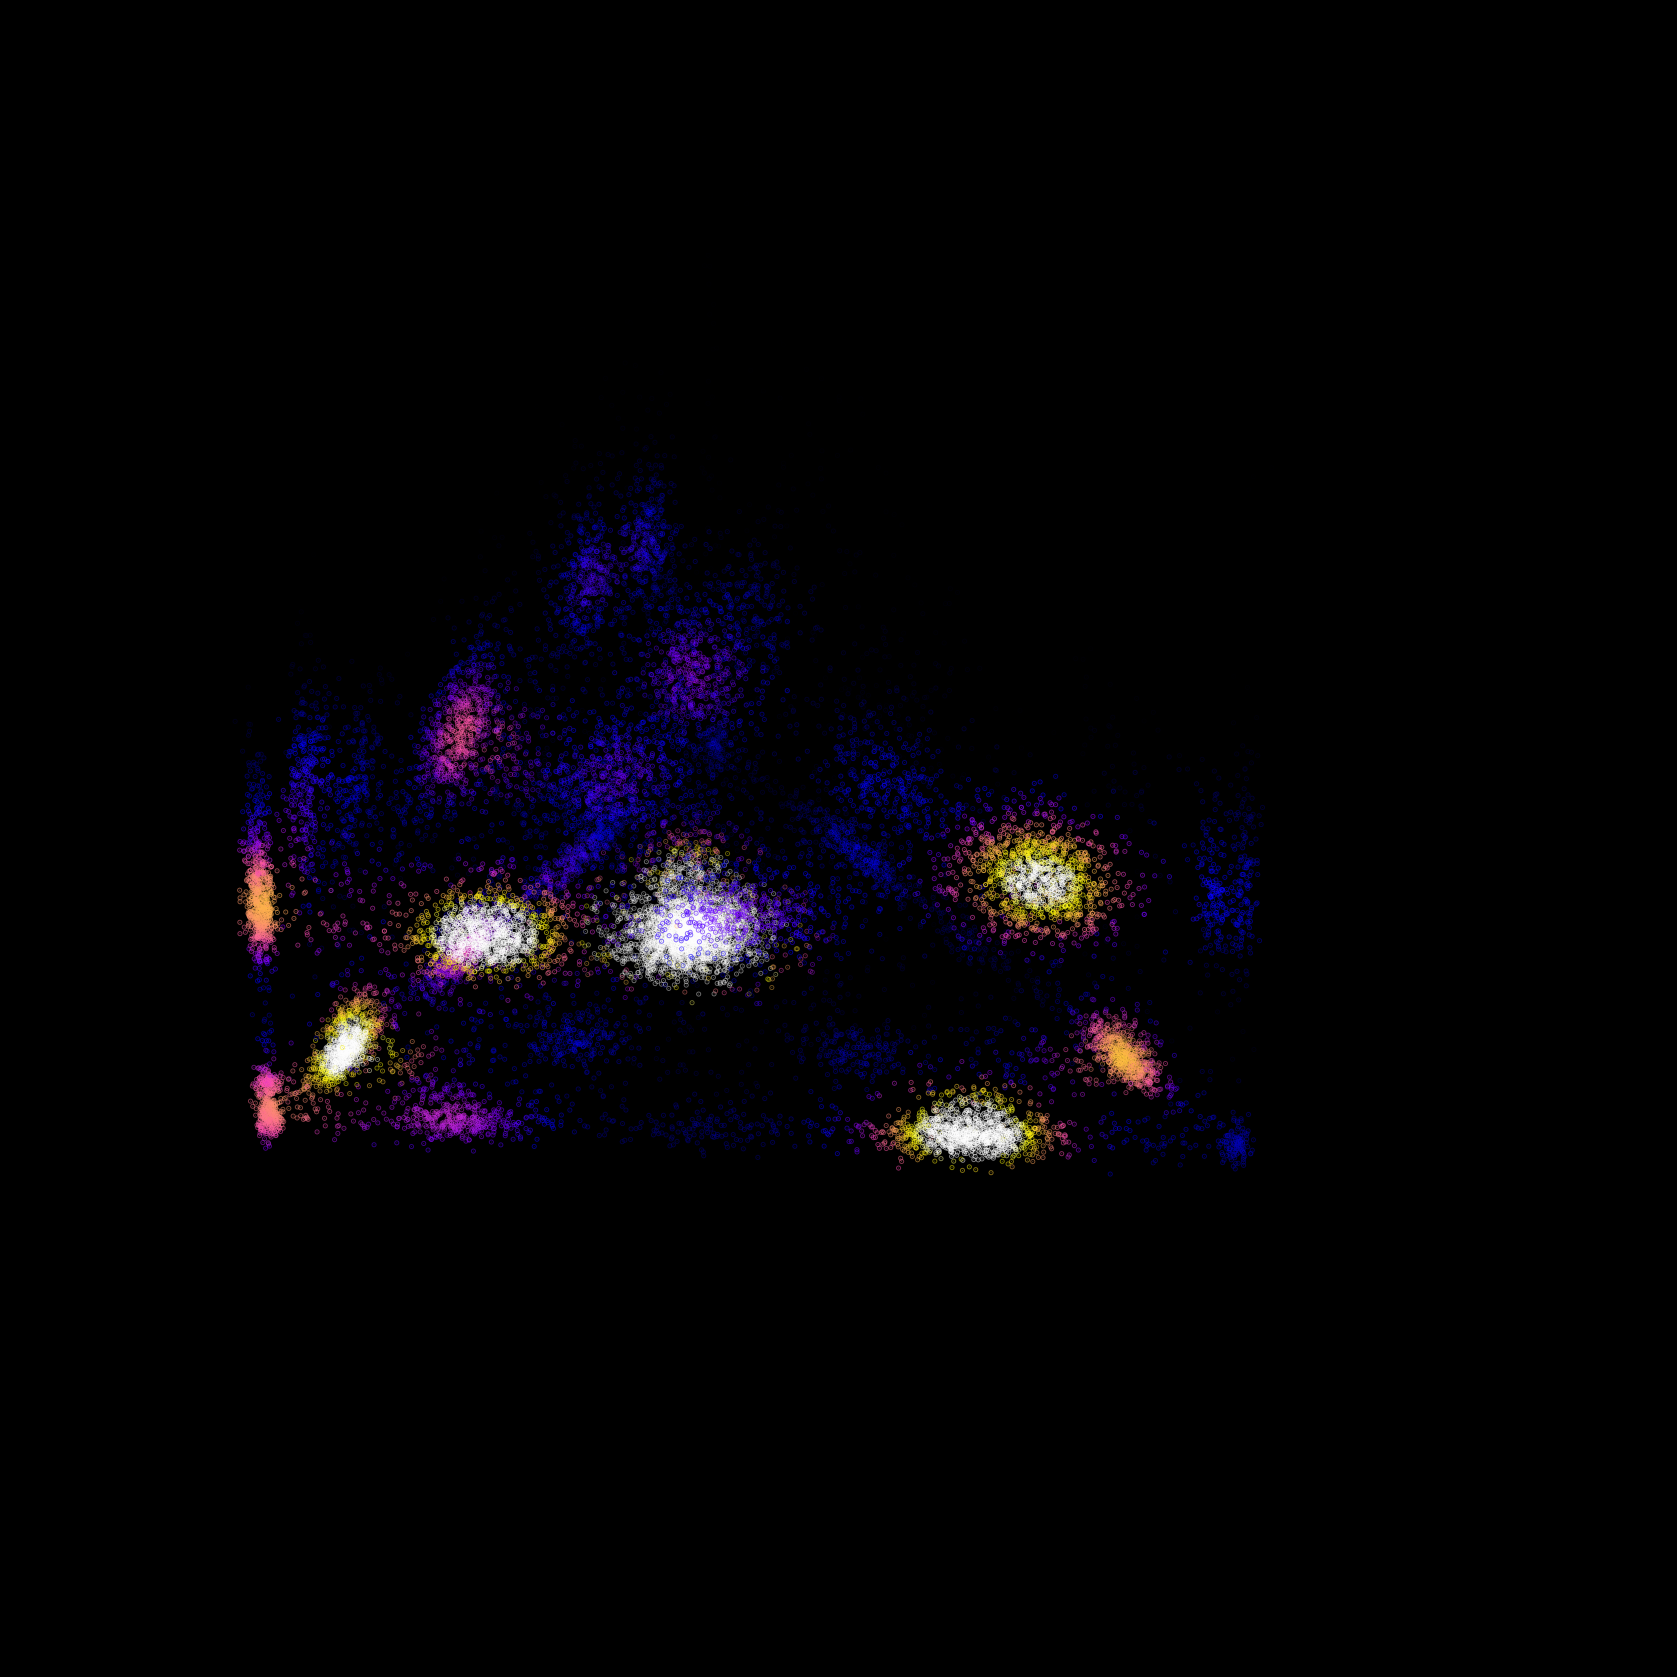

In [ ]:
# from scipy import stats

# data = intensity.sample(20000)

# x = np.array(data['X_coor_gaussian'])
# y = np.array(data['Y_coor_gaussian'])
# z = np.array(data['G/A'])
# xyz = np.vstack([x,y,z])
# density = stats.gaussian_kde(xyz)(xyz) 

# idx = density.argsort()
# x, y, z, density = x[idx], y[idx], z[idx], density[idx]
# fig = plt.figure(figsize=(7, 7))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(x, y, z, c=density, cmap=plt.cm.gnuplot2, s=0.05, vmin=0, vmax=10) 
# ax.set_zlim3d(-0.1,0.5)
# ax.view_init(elev=30, azim=30)

# fig.set_facecolor('black')
# ax.set_facecolor('black') 
# ax.grid(False) 
# ax.set_axis_off()

# separation by GMM

In [14]:
# from sklearn.mixture import GaussianMixture as GMM
# from scipy.spatial.distance import euclidean


# def apply_gmm(reduced_features, num_clusters, means_init=None):
#     gmm = GMM(n_components=num_clusters, covariance_type='diag', means_init=means_init)
#     gmm_clusters = gmm.fit(reduced_features)
#     labels = gmm_clusters.predict(reduced_features)
#     return  gmm_clusters, labels

# intensity['label'] = -1
# GMM_dict = dict()
# for layer in range(GLAYER):
#     centroids_init = centroid_init_dict[layer]
#     filtered_data = intensity[intensity['G_layer'] == layer]
#     reduced_features = filtered_data[Q_CHANNELS]
#     gmm, gmm_labels = apply_gmm(reduced_features, num_clusters=len(centroids_init), means_init=centroids_init)
#     GMM_dict[layer] = gmm 
#     intensity.loc[filtered_data.index, 'label'] = gmm_labels + int(layer * Q_NUM + 1)
from sklearn.mixture import GaussianMixture as GMM

def apply_gmm(reduced_features, num_clusters, means_init=None):
    """应用高斯混合模型进行聚类"""
    gmm = GMM(n_components=num_clusters, covariance_type='diag', means_init=means_init)
    gmm.fit(reduced_features)
    labels = gmm.predict(reduced_features)
    return gmm, labels

# 单层聚类处理
intensity['label'] = -1  # 初始化标签列

# 获取聚类中心初始化数据
centroids_init = centroid_init_dict[0]  # 只有一层，索引为0

# 使用所有数据进行聚类
reduced_features = intensity[Q_CHANNELS]
gmm, gmm_labels = apply_gmm(
    reduced_features, 
    num_clusters=len(centroids_init), 
    means_init=centroids_init
)

# 分配标签（从1开始）
intensity['label'] = gmm_labels + 1

# 保存GMM模型（可选）
GMM_model = gmm  # 不再需要字典存储多层模型

KeyError: 0

KeyError: 0

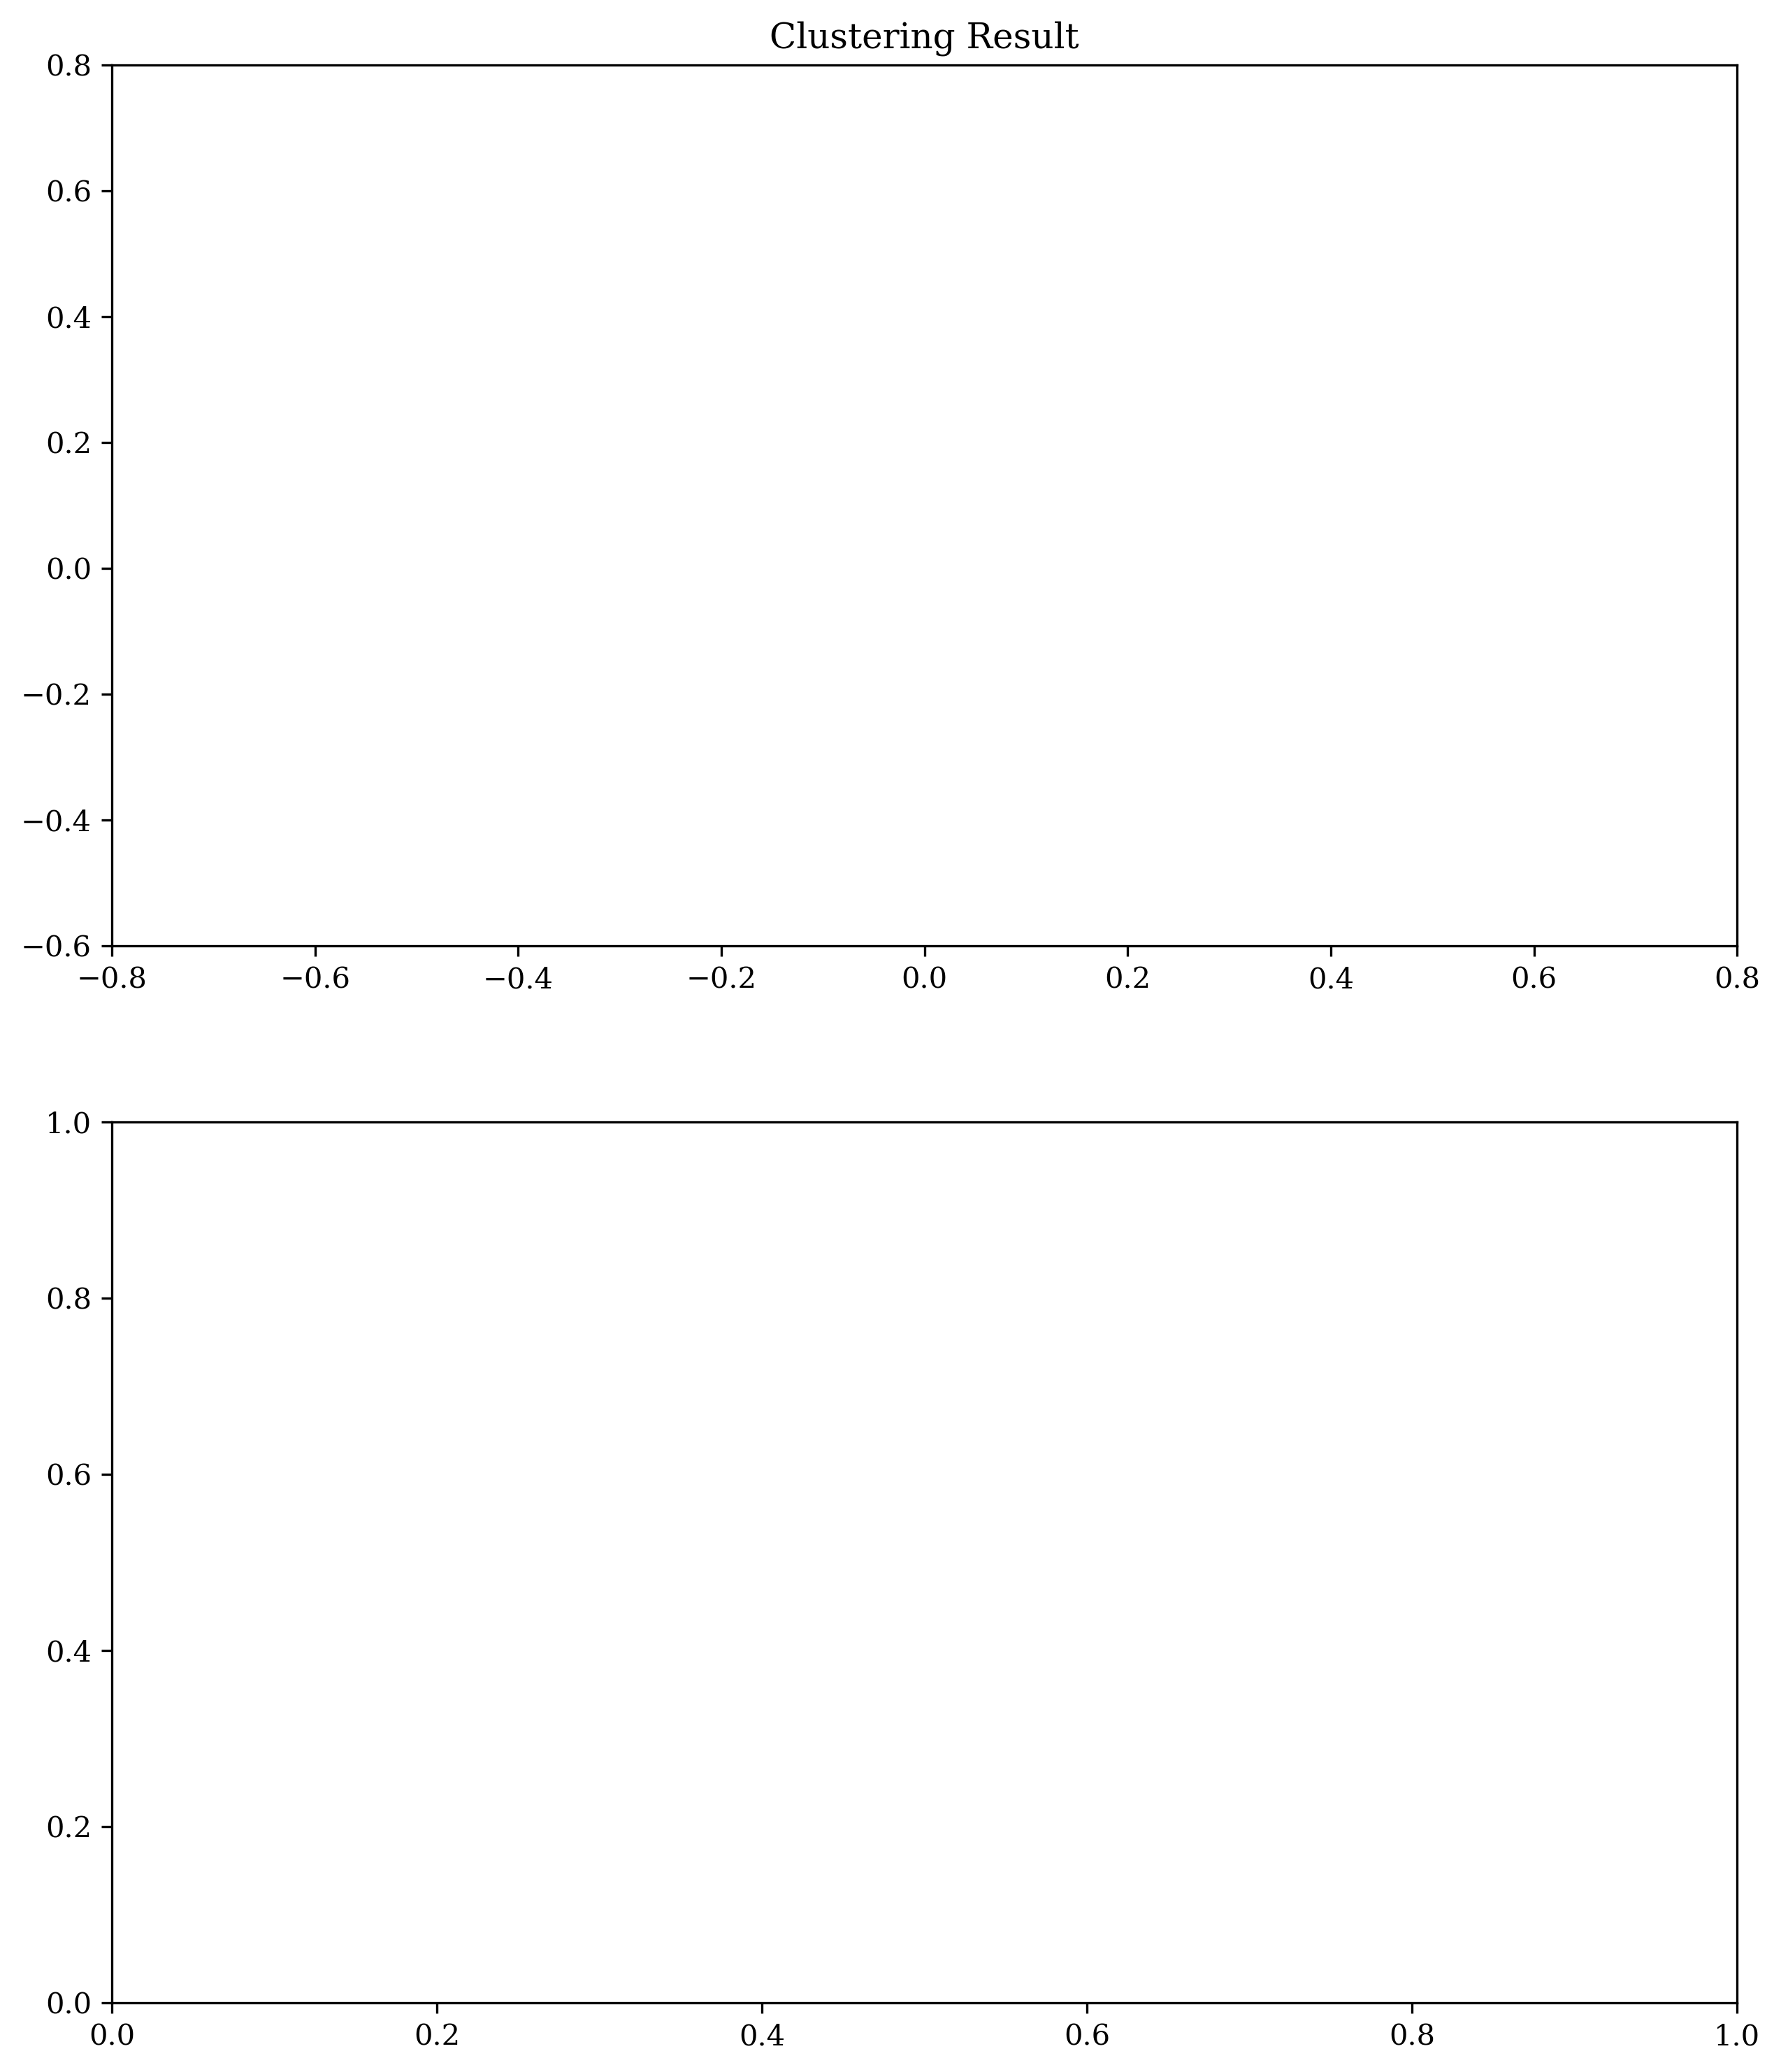

In [15]:
# bins = (500, 500)
# percentile_thre = 98

# fig, ax = plt.subplots(nrows=2, ncols=GLAYER, figsize=(5.5 * GLAYER, 10))
# for layer in range(GLAYER):
#     ax_gmm = ax[0] if GLAYER < 2 else ax[0, layer]
#     ax_hist = ax[1] if GLAYER < 2 else ax[1, layer]
#     data = intensity[intensity['G_layer'] == layer]
#     data = data[data['label'] != -1]
#     gmm = GMM_dict[layer]
    
#     # ax_gmm.scatter(data['X_coor_gaussian'], data['Y_coor_gaussian'], c=data['label'], marker='.', alpha=0.1, s=0.1)
    
#     ax_gmm.scatter(data['X_coor_gaussian'], data['Y_coor_gaussian'], label=data['label'],
#                    c=[colormap[layer][label] for label in data['label']], marker='.', alpha=alpha, s=s, )
#     for i in range(1 + layer * Q_NUM, 1 + (layer+1) * Q_NUM):
#         cen_tmp = np.mean(data[data['label']==i][['X_coor_gaussian', 'Y_coor_gaussian']], axis=0)
#         ax_gmm.text(cen_tmp[0], cen_tmp[1], i, fontsize=12, color='black', ha='center', va='center')
#     RYB_xy_transform = np.concatenate([RYB_x_transform, RYB_y_transform], axis=1)
#     centroid_init = centroid_init_dict[layer] @ RYB_xy_transform
#     ax_gmm.scatter(centroid_init[:, 0], centroid_init[:, 1], color='cyan', s=1.5, alpha=0.7)

#     ax_gmm.set_title(f'G={layer}')
#     ax_gmm.set_xlim(XRANGE)
#     ax_gmm.set_ylim(YRANGE)

#     x, y = data['X_coor_gaussian'], data['Y_coor_gaussian']
#     hist, xedges, yedges = np.histogram2d(x, y, bins=bins)
#     percentile = np.percentile(hist, percentile_thre)
#     ax_hist.hist2d(x, y, bins=bins, vmax=percentile,
#                    range=[XRANGE, YRANGE], cmap='inferno')
#     ax_hist.set_xlim(XRANGE)
#     ax_hist.set_ylim(YRANGE)

# axes = ax.flat
# for i in range(len(axes)):
#     ax = axes[i]
#     ax.set_xticks([])
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.set_xlabel('')
#     ax.set_ylabel('')
#     ax.set_title('')
#     bbox = ax.get_tightbbox(fig.canvas.get_renderer())
#     bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
#     plt.savefig(figure_dir / f'{i//GLAYER+1}-layer{i%GLAYER+1}.png', bbox_inches=bbox)

# plt.tight_layout()
# plt.savefig(figure_dir / 'ColorSpace_GMM.png', dpi=300)

bins = (500, 500)
percentile_thre = 98

# 单层处理
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

# 获取数据
data = intensity[intensity['label'] != -1]  # 使用所有有效标签的数据

# 散点图（左上）
ax[0].scatter(data['X_coor_gaussian'], data['Y_coor_gaussian'], 
             c=[colormap[label] for label in data['label']], 
             marker='.', alpha=alpha, s=s)
ax[0].set_title('Clustering Result')
ax[0].set_xlim(XRANGE)
ax[0].set_ylim(YRANGE)

# 添加聚类中心标签
for i in range(1, Q_NUM + 1):
    cluster_data = data[data['label'] == i]
    if len(cluster_data) > 0:
        cen_tmp = np.mean(cluster_data[['X_coor_gaussian', 'Y_coor_gaussian']], axis=0)
        ax[0].text(cen_tmp[0], cen_tmp[1], str(i), 
                  fontsize=12, color='black', 
                  ha='center', va='center',
                  bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# 添加初始聚类中心（可选）
RYB_xy_transform = np.concatenate([RYB_x_transform, RYB_y_transform], axis=1)
centroid_init = centroid_init_dict[0] @ RYB_xy_transform
ax[0].scatter(centroid_init[:, 0], centroid_init[:, 1], 
             color='cyan', s=20, alpha=0.7, marker='x')

# 密度图（左下）
x, y = data['X_coor_gaussian'], data['Y_coor_gaussian']
hist, xedges, yedges = np.histogram2d(x, y, bins=bins)
percentile = np.percentile(hist, percentile_thre)
ax[1].hist2d(x, y, bins=bins, vmax=percentile,
            range=[XRANGE, YRANGE], cmap='inferno')
ax[1].set_title('Density Distribution')
ax[1].set_xlim(XRANGE)
ax[1].set_ylim(YRANGE)

# 添加颜色条
plt.colorbar(ax[1].collections[0], ax=ax[1], label='Point Density')

# 高质量点筛选（可选）
sub = data[(data['sum'] > 1000) & (data['sum'] < 15000)]

# 高质量点散点图（右上）
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax2.scatter(sub['X_coor_gaussian'], sub['Y_coor_gaussian'], 
           c=[colormap[label] for label in sub['label']], 
           marker='.', alpha=alpha, s=s)
ax2.set_title('High Quality Points')
ax2.set_xlim(XRANGE)
ax2.set_ylim(YRANGE)

# 高质量点密度图（右下）
ax3 = plt.subplot2grid((2, 2), (1, 1))
x_sub, y_sub = sub['X_coor_gaussian'], sub['Y_coor_gaussian']
hist_sub, _, _ = np.histogram2d(x_sub, y_sub, bins=bins)
percentile_sub = np.percentile(hist_sub, percentile_thre)
ax3.hist2d(x_sub, y_sub, bins=bins, vmax=percentile_sub,
          range=[XRANGE, YRANGE], cmap='inferno')
ax3.set_title('High Quality Density')
ax3.set_xlim(XRANGE)
ax3.set_ylim(YRANGE)

# 添加颜色条
plt.colorbar(ax3.collections[0], ax=ax3, label='Point Density')

# 调整布局并保存
plt.tight_layout()
plt.savefig(figure_dir / 'ColorSpace_GMM.png', dpi=300, bbox_inches='tight')
plt.close()

In [16]:
print(len(intensity_raw))
print(len(intensity))

1785991
1785991


## mannual revise using mask

In [ ]:
# from lib.mannual_thre import draw_mask_mannual

# os.makedirs(read_dir / 'masks', exist_ok=True)
# draw_mask_mannual(image_path = str(read_dir / 'figures' / '2-layer2.png'),
#                   mask_path = str(read_dir / 'masks' / 'mask_30.png'),)


In [ ]:
# from lib.mannual_thre import relabel

# intensity = relabel(intensity, mask_dir=read_dir/'masks', mode='replace', num_per_layer=Q_NUM, xrange=XRANGE, yrange=YRANGE)
# intensity = relabel(intensity, mask_dir=read_dir/'masks', mode='discard', num_per_layer=Q_NUM, xrange=XRANGE, yrange=YRANGE)

Relabeling, mode=discard: 100%|██████████| 30/30 [00:13<00:00,  2.22it/s]


In [ ]:
# print(len(intensity))

1679454


## visualization


In [ ]:
# def visualization(intensity_fra,
#                   G_layer=3,
#                   num_per_layer=21,
#                   bins = [100, 100],
#                   percentile_thre=90,
#                   XRANGE=[-0.8, 0.8],
#                   YRANGE=[-0.6, 0.8],
#                   out_path_dir=None,
#                   colormap_dict=None,
#                   label=True,):
    
#     s = 1 / np.log2(len(intensity_fra)) *5
#     alpha = 1 / np.log2(len(intensity_fra)) 

#     fig, ax = plt.subplots(nrows=2, ncols=G_layer, figsize=(5.5 * G_layer, 10))
#     for layer in tqdm(range(G_layer)):
#         data = intensity_fra[intensity_fra['G_layer'] == layer]
#         x, y = data['X_coor_gaussian'], data['Y_coor_gaussian']
#         ax_scatter = ax[0] if G_layer < 2 else ax[0, layer]
#         if label and colormap_dict: 
#             colormap = [colormap_dict[layer][label] for label in data['label']]
#             ax_scatter.scatter(data['X_coor_gaussian'], data['Y_coor_gaussian'], c=colormap, label=data['label'], marker='.', alpha=alpha, s=s)
#         elif label:
#             ax_scatter.scatter(data['X_coor_gaussian'], data['Y_coor_gaussian'], c=data['label'], marker='.', alpha=alpha, s=s)
#             for i in range(1 + layer * num_per_layer, 1 + (layer+1) * num_per_layer):
#                 data_tmp = data[data['label']==i]
#                 cen_tmp = np.mean(data_tmp[['X_coor_gaussian', 'Y_coor_gaussian']], axis=0)
#                 ax_scatter.text(cen_tmp[0], cen_tmp[1], i, fontsize=12, color='black', ha='center', va='center')
#         else: ax_scatter.scatter(data['X_coor_gaussian'], data['Y_coor_gaussian'], marker='.', alpha=alpha, s=s)

#         ax_scatter.set_xlim(XRANGE)
#         ax_scatter.set_ylim(YRANGE)
#         ax_scatter.set_title(f'G={layer}')


#         ax_density = ax[1] if G_layer < 2 else ax[1, layer]
#         hist, xedges, yedges = np.histogram2d(x, y, bins=bins)
#         percentile = np.percentile(hist, percentile_thre)
#         ax_density.hist2d(x, y, bins=bins, vmax=percentile, range=[XRANGE, YRANGE], cmap='inferno')

#     plt.tight_layout()
#     if out_path_dir == None: plt.show()
#     else: plt.savefig(out_path_dir, bbox_inches = 'tight')

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:01<00:00,  1.66it/s]


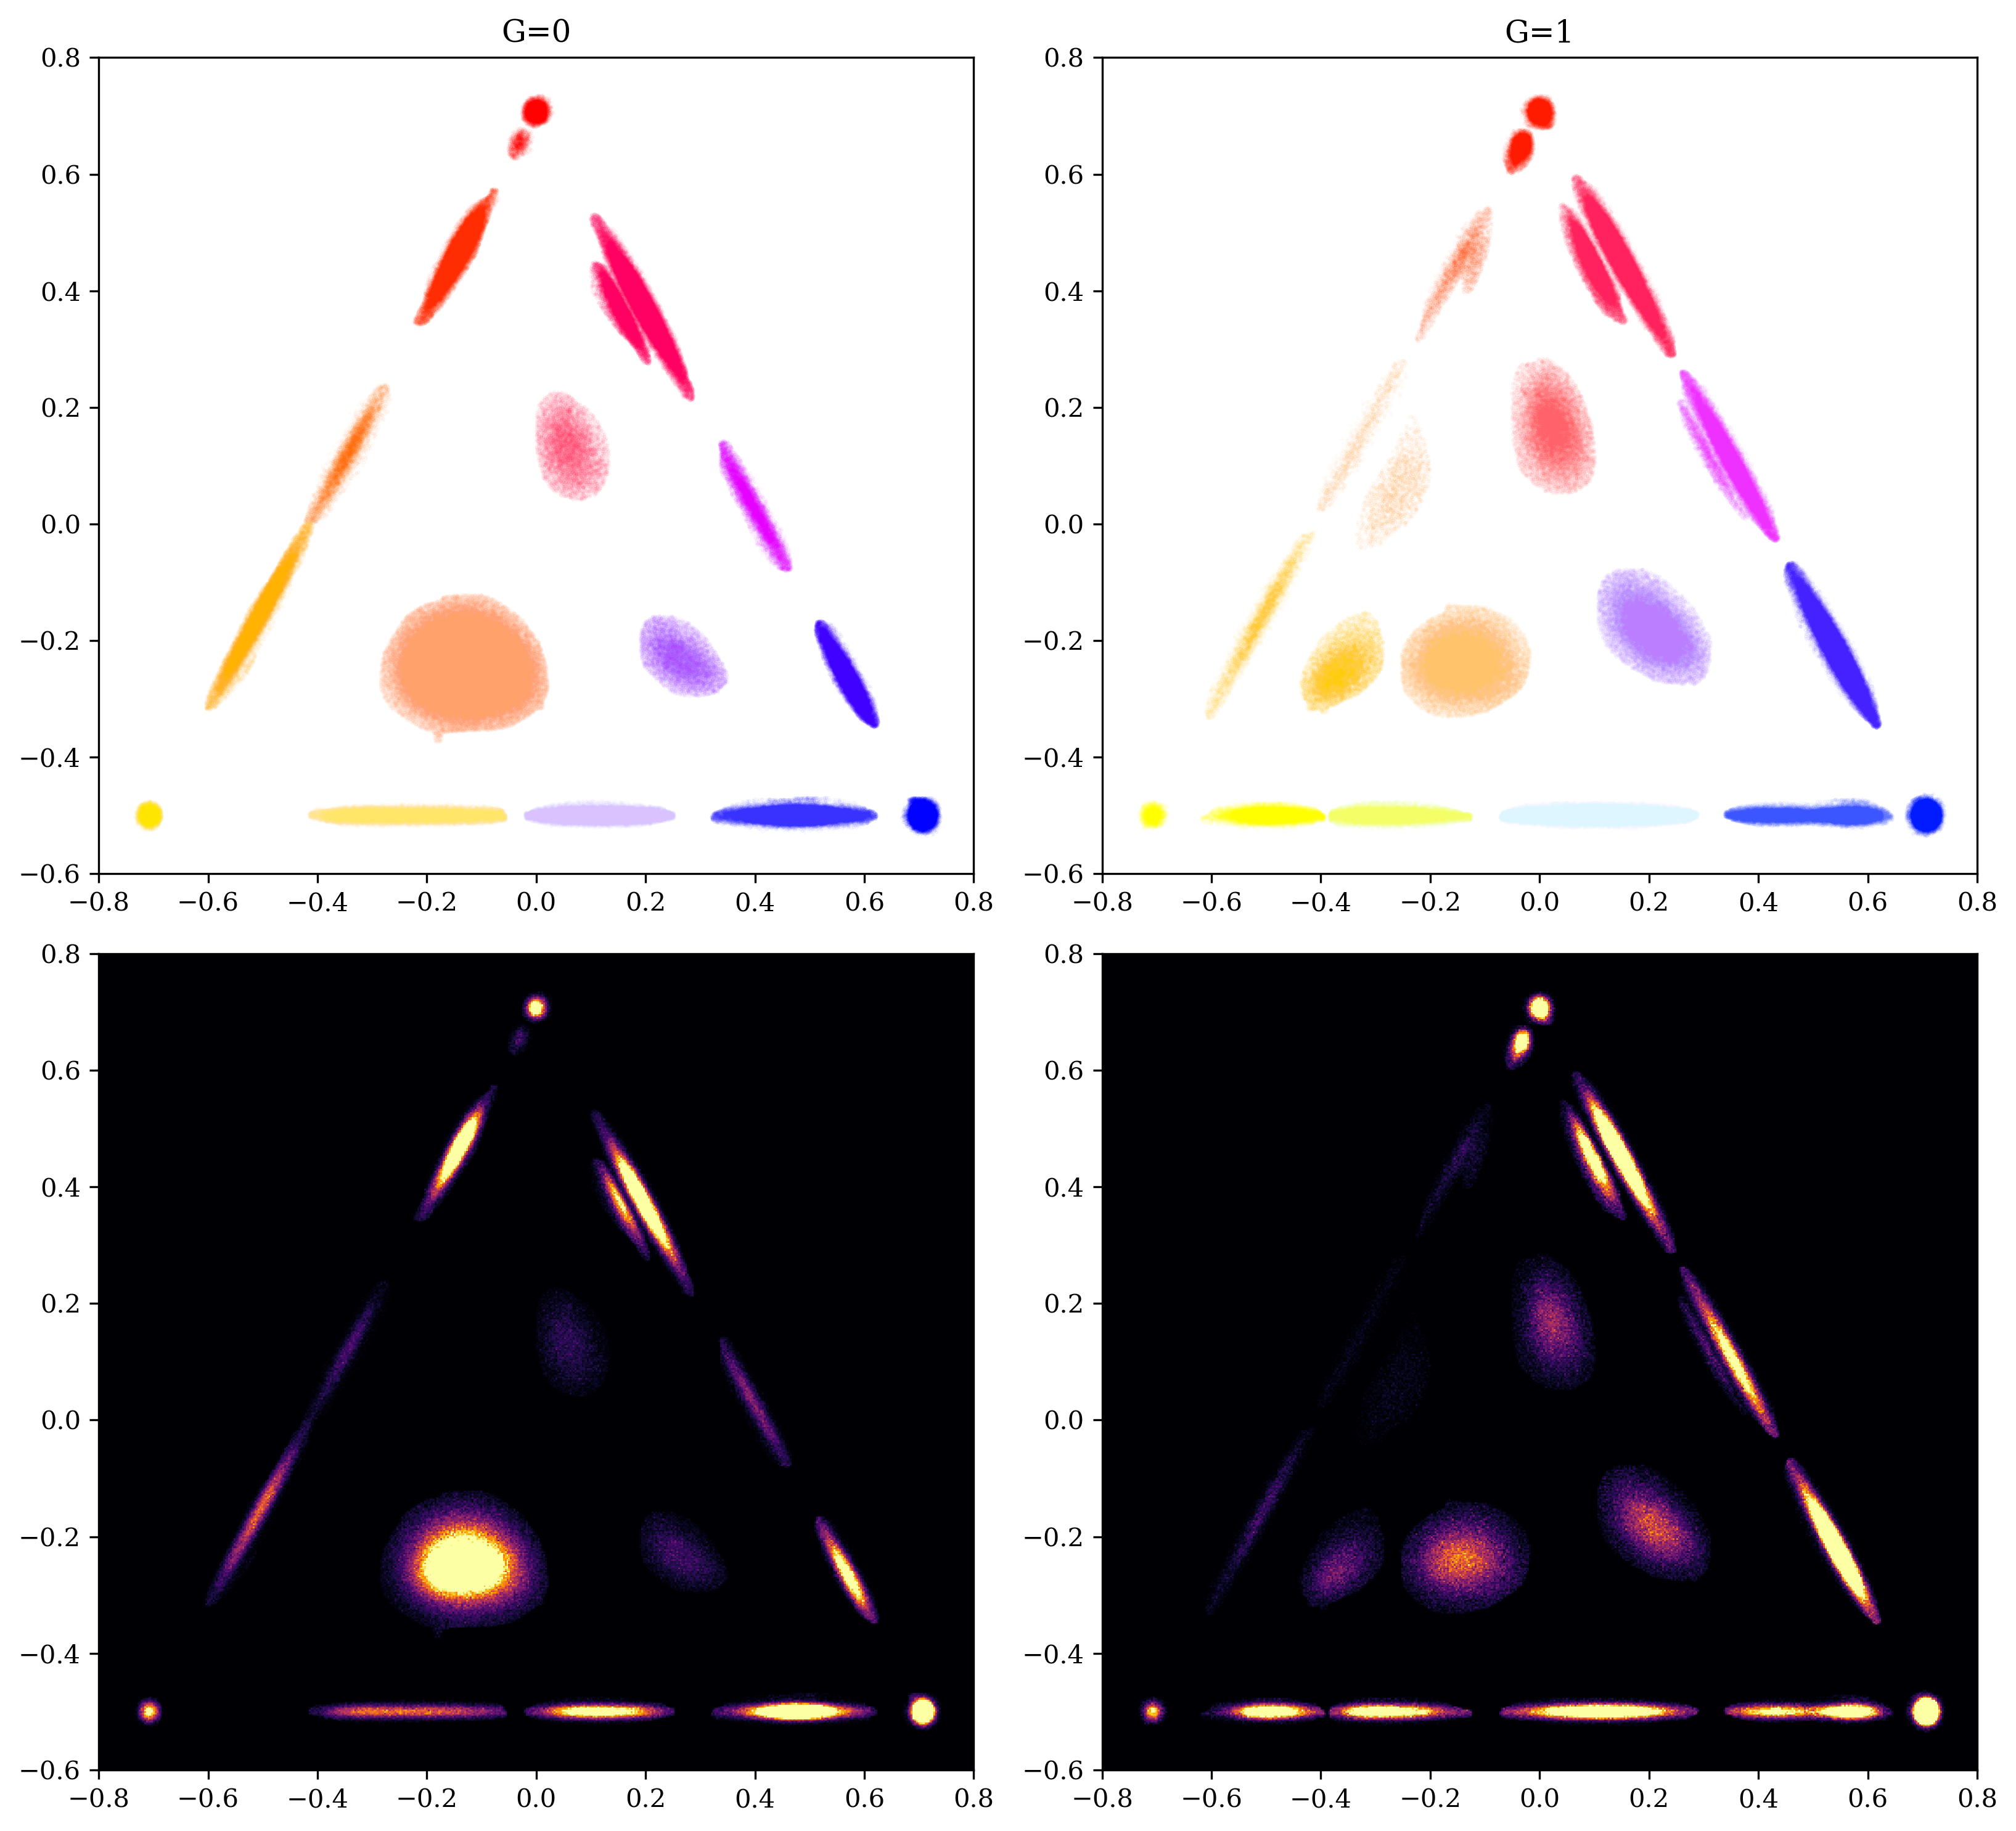

In [ ]:
# visualization(intensity, G_layer=2, num_per_layer=15, 
#               bins=[500, 500], percentile_thre=99, colormap_dict=colormap, 
#               XRANGE=XRANGE, YRANGE=YRANGE)

In [17]:
def viz_simple(data, cmap=None, bins=(500,500), p_thre=99, out_path=None):
    """简化版可视化函数"""
    s, alpha = 5/np.log2(len(data)), 1/np.log2(len(data))
    fig, ax = plt.subplots(2, 1, figsize=(6, 10))
    
    # 散点图
    colors = [cmap[l] for l in data['label']] if cmap else data['label']
    ax[0].scatter(data['X_coor_gaussian'], data['Y_coor_gaussian'], 
                  c=colors, marker='.', alpha=alpha, s=s)
    
    # 密度图
    x, y = data['X_coor_gaussian'], data['Y_coor_gaussian']
    h, _, _ = np.histogram2d(x, y, bins=bins)
    vmax = np.percentile(h, p_thre)
    im = ax[1].hist2d(x, y, bins=bins, vmax=vmax, cmap='inferno')
    
    # 设置坐标轴
    for a in ax:
        a.set_xlim(XRANGE)
        a.set_ylim(YRANGE)
    
    plt.colorbar(im[3], ax=ax[1])
    plt.tight_layout()
    plt.savefig(out_path, bbox_inches='tight', dpi=300) if out_path else plt.show()
    plt.close()

In [18]:
viz_simple(intensity[intensity['G_layer'] == 0], 
           cmap=colormap, 
           out_path=figure_dir / 'G0_simple.png')

# Quantitative analysis of GMM cluster quality

## cluster points num distribution

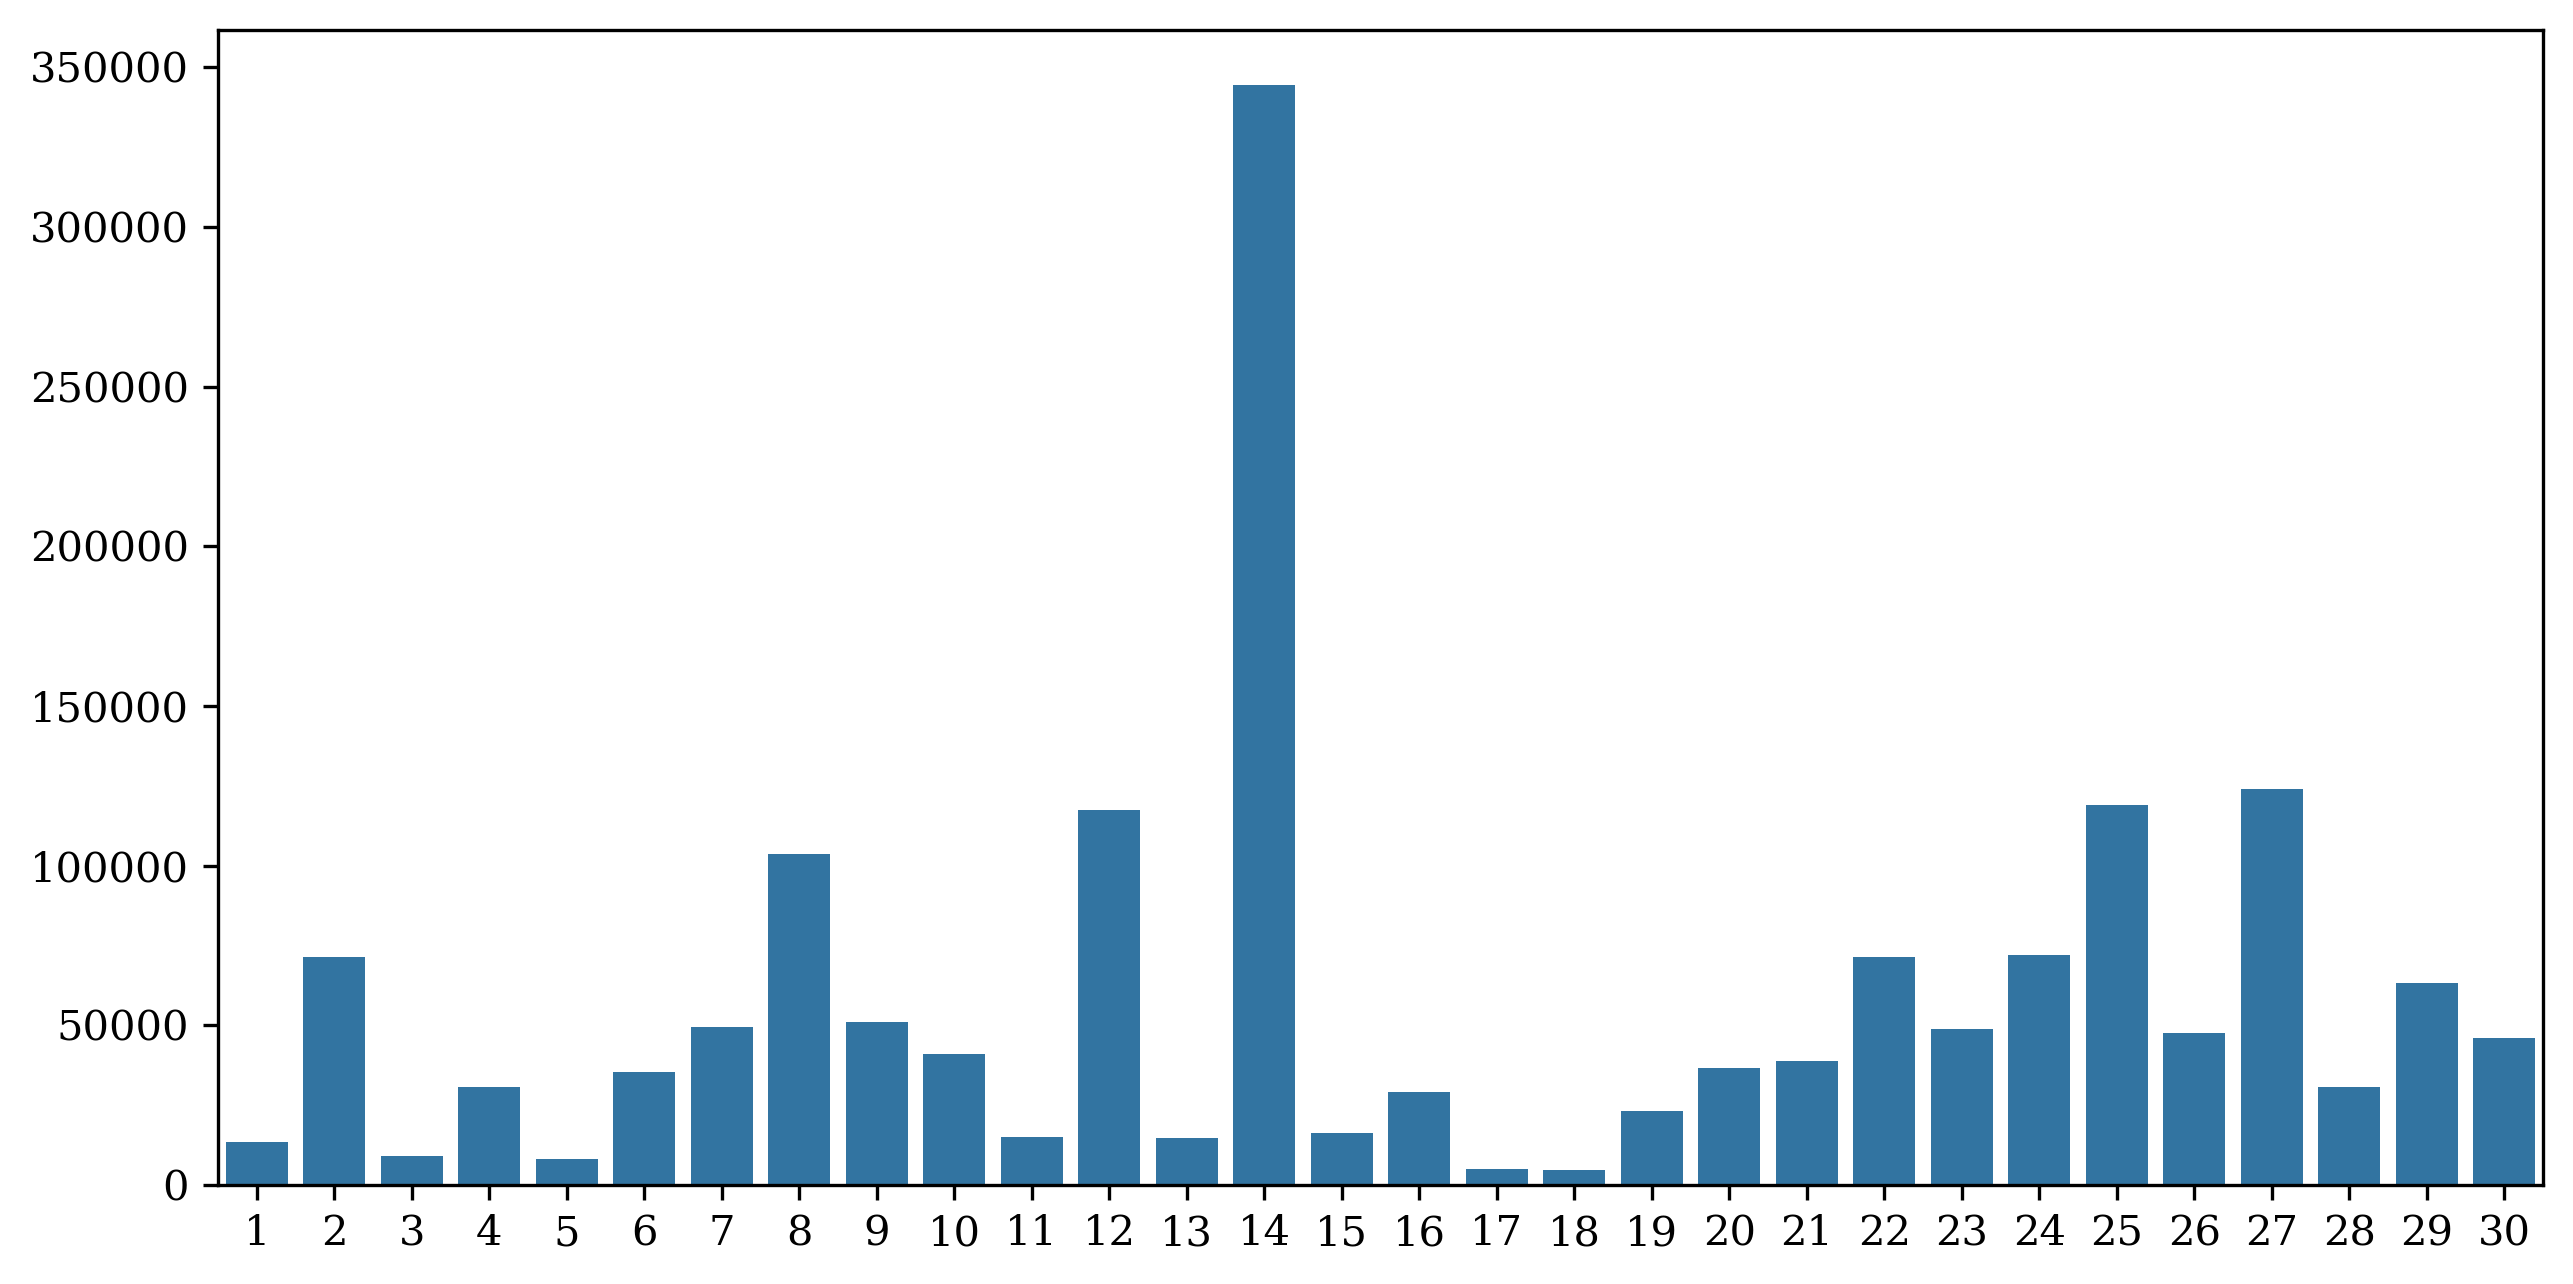

In [ ]:
# data = intensity.copy()
# plt.figure(figsize=(Q_NUM * GLAYER / 3, 5))
# sns.barplot(x = [cluster_num + 1 for cluster_num in range(Q_NUM * GLAYER)], 
#             y = [len(data[data['label']==cluster_num+1]) for cluster_num in range(Q_NUM * GLAYER)])
# plt.show()

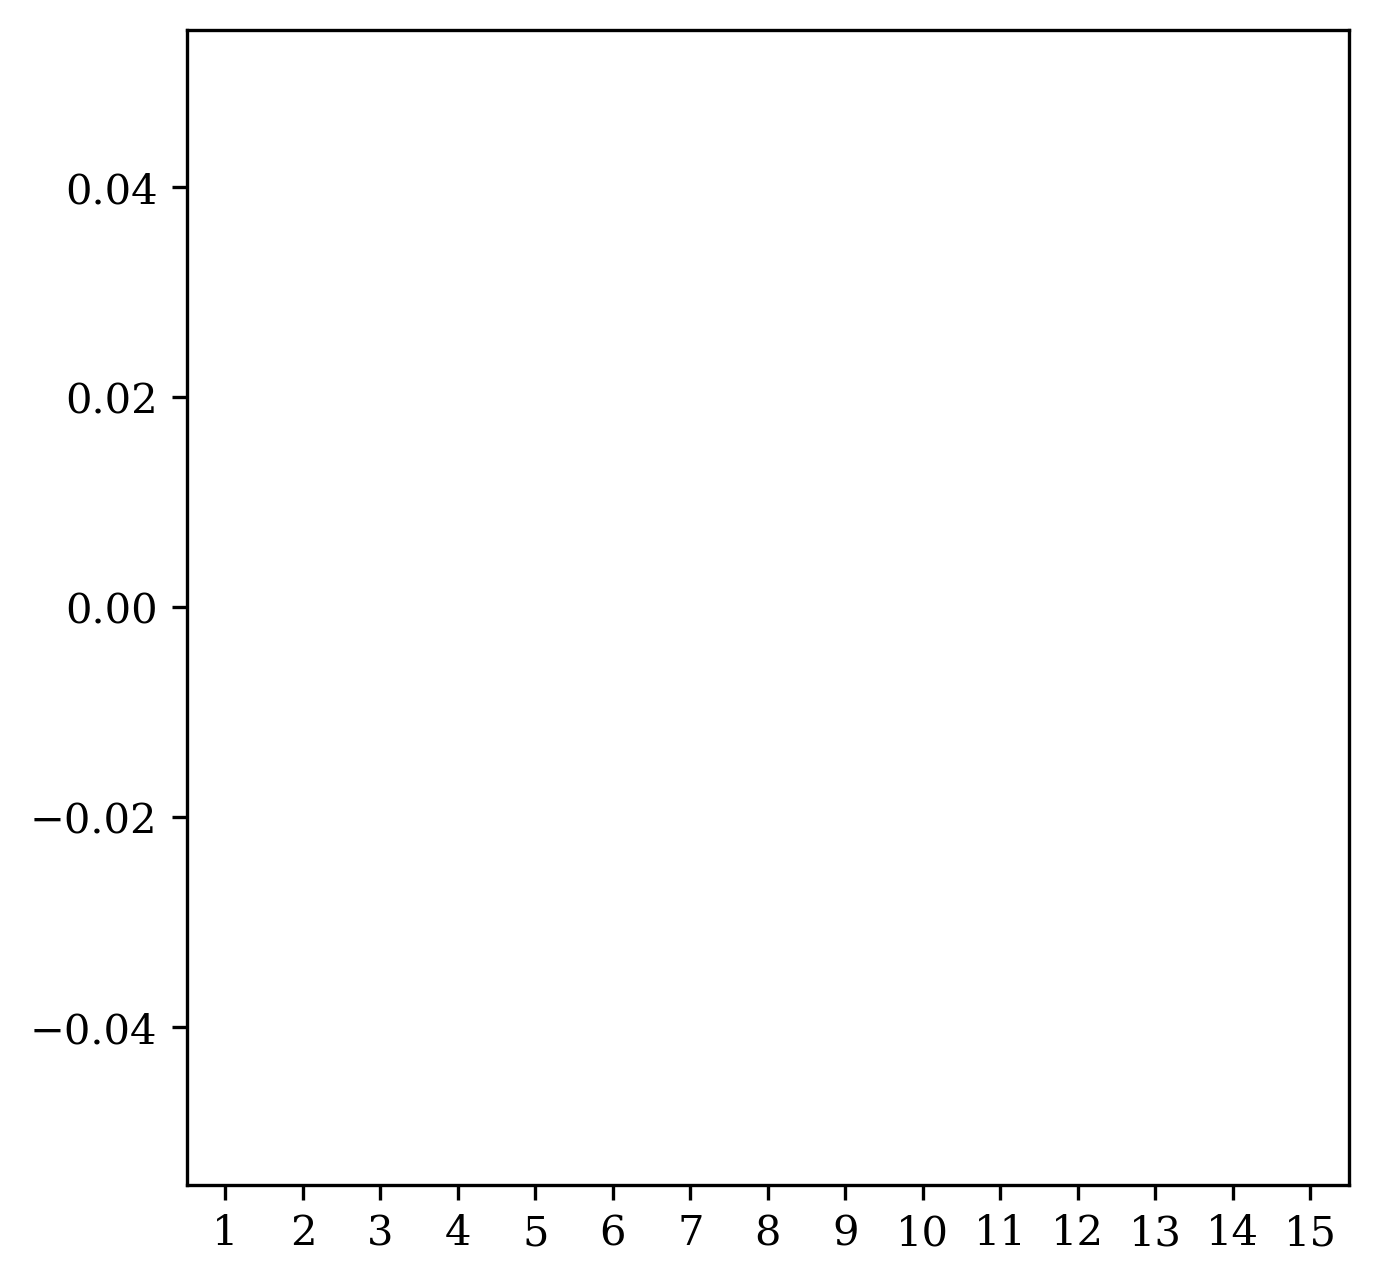

In [19]:
data = intensity.copy()
plt.figure(figsize=(Q_NUM * GLAYER / 3, 5))
sns.barplot(x = [cluster_num + 1 for cluster_num in range(Q_NUM * GLAYER)], 
            y = [len(data[data['label']==cluster_num+1]) for cluster_num in range(Q_NUM * GLAYER)])
plt.show()

## cdf related analysis

In [86]:
from tqdm import tqdm
from scipy import stats
import numpy as np


def calculate_cdf_gmm(X_sub, gmm, st):
    X_sub_cal = X_sub[['Ye/A', 'B/A', 'R/A',]]
    # Get the of each cluster
    cdfs_df = pd.DataFrame()

    for i in tqdm(range(gmm.n_components), desc='component'):
        if gmm.covariance_type == 'tied':
            mean = gmm.means_[i]
            cov = gmm.covariances_
        elif gmm.covariance_type == 'diag':
            mean = gmm.means_[i]
            cov = np.diag(gmm.covariances_[i])

        m_dist_x = (X_sub_cal-mean) @ np.linalg.inv(cov)
        m_dist_x = np.einsum('ij,ji->i', m_dist_x, (X_sub_cal-mean).T)

        probability = 1 - stats.chi2.cdf(np.array(m_dist_x), 3)
        cdfs_df[i + 1 + st] = probability
        
    cdfs_df.index = X_sub.index

    return cdfs_df


def calculate_cdf_mannual(intensity, st, num_per_layer, channel=['Ye/A', 'B/A', 'R/A',]):
    centroids = []
    cdfs_df = pd.DataFrame()
    for i in tqdm(range(st + 1, st + num_per_layer + 1), desc='component'):
        data_cdf = intensity[channel]
        data = intensity[intensity['label'] == i]
        data = data[channel]
        points = np.array(data)
        
        # calculate the mean
        mean = np.mean(points, axis=0)

        # calculate the covariance matrix
        cov = np.cov(points, rowvar=False)

        # calculate cdf
        m_dist_x = (data_cdf - mean) @ np.linalg.pinv(cov)
        m_dist_x = np.einsum('ij,ji->i', m_dist_x, (data_cdf - mean).T)
        probability = 1 - stats.chi2.cdf(np.array(m_dist_x), len(channel))
        cdfs_df[i] = probability
        centroids.append(mean)
    centroids = np.array(centroids)
    cdfs_df.index = intensity.index

    return cdfs_df, centroids

### cdf_4d

#### calculation

In [87]:
cdf_4d, centroids = calculate_cdf_mannual(intensity, st=0, num_per_layer=GLAYER*Q_NUM, channel=['Ye/A', 'B/A', 'R/A', 'G/A'])

component: 100%|██████████| 30/30 [00:08<00:00,  3.52it/s]


#### evaluation

In [88]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mean_accuracy(cdfs_df, X_sub, sample=50, y_line=0.95, total_num=GLAYER*Q_NUM, 
                       out_path=read_dir / 'figures', ax=ax):
    sample = 50
    p_thre_list = [_/sample for _ in range(sample)]
    accuracy = []

    for _, p_thre in tqdm(enumerate(p_thre_list), total=len(p_thre_list), desc='accuracy'):
        overlap = pd.DataFrame()

        for cluster_num in range(1, total_num+1):
            tmp = cdfs_df.loc[X_sub['label'][X_sub['label']==(cluster_num)].index]
            overlap[cluster_num] = (tmp>p_thre).sum(axis=0)/len(tmp)
        add = np.diag(overlap) / overlap.sum(axis=1)
        accuracy.append(add)
        overlap = pd.concat([overlap, pd.DataFrame(add).T], axis=0)

    accuracy = np.array(accuracy)

    # Create data
    x = p_thre_list
    y = np.mean(accuracy,axis=1)

    indices = np.where(np.diff(np.sign(y - y_line)))[0][0]
    x_intercepts = x[indices]
    y_intercepts = y[indices]

    # Plot the first dataset on primary axes
    ax.plot(x, y, 'b-')
    ax.set_xlabel('P_thre')
    ax.set_ylabel('mean', color='b')
    ax.tick_params('y', colors='b')

    ax.axhline(y_line, color='r', linestyle='--', label=f'y = {y_line}')
    for x_i, y_i in zip([x_intercepts], [y_intercepts]):
        plt.plot(x_i, y_i, 'ko')
        plt.text(x_i, y_i, f'({x_i:.2f}, {y_i:.2f})')
    ax.set_title("Confidence")

    return accuracy

accuracy: 100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


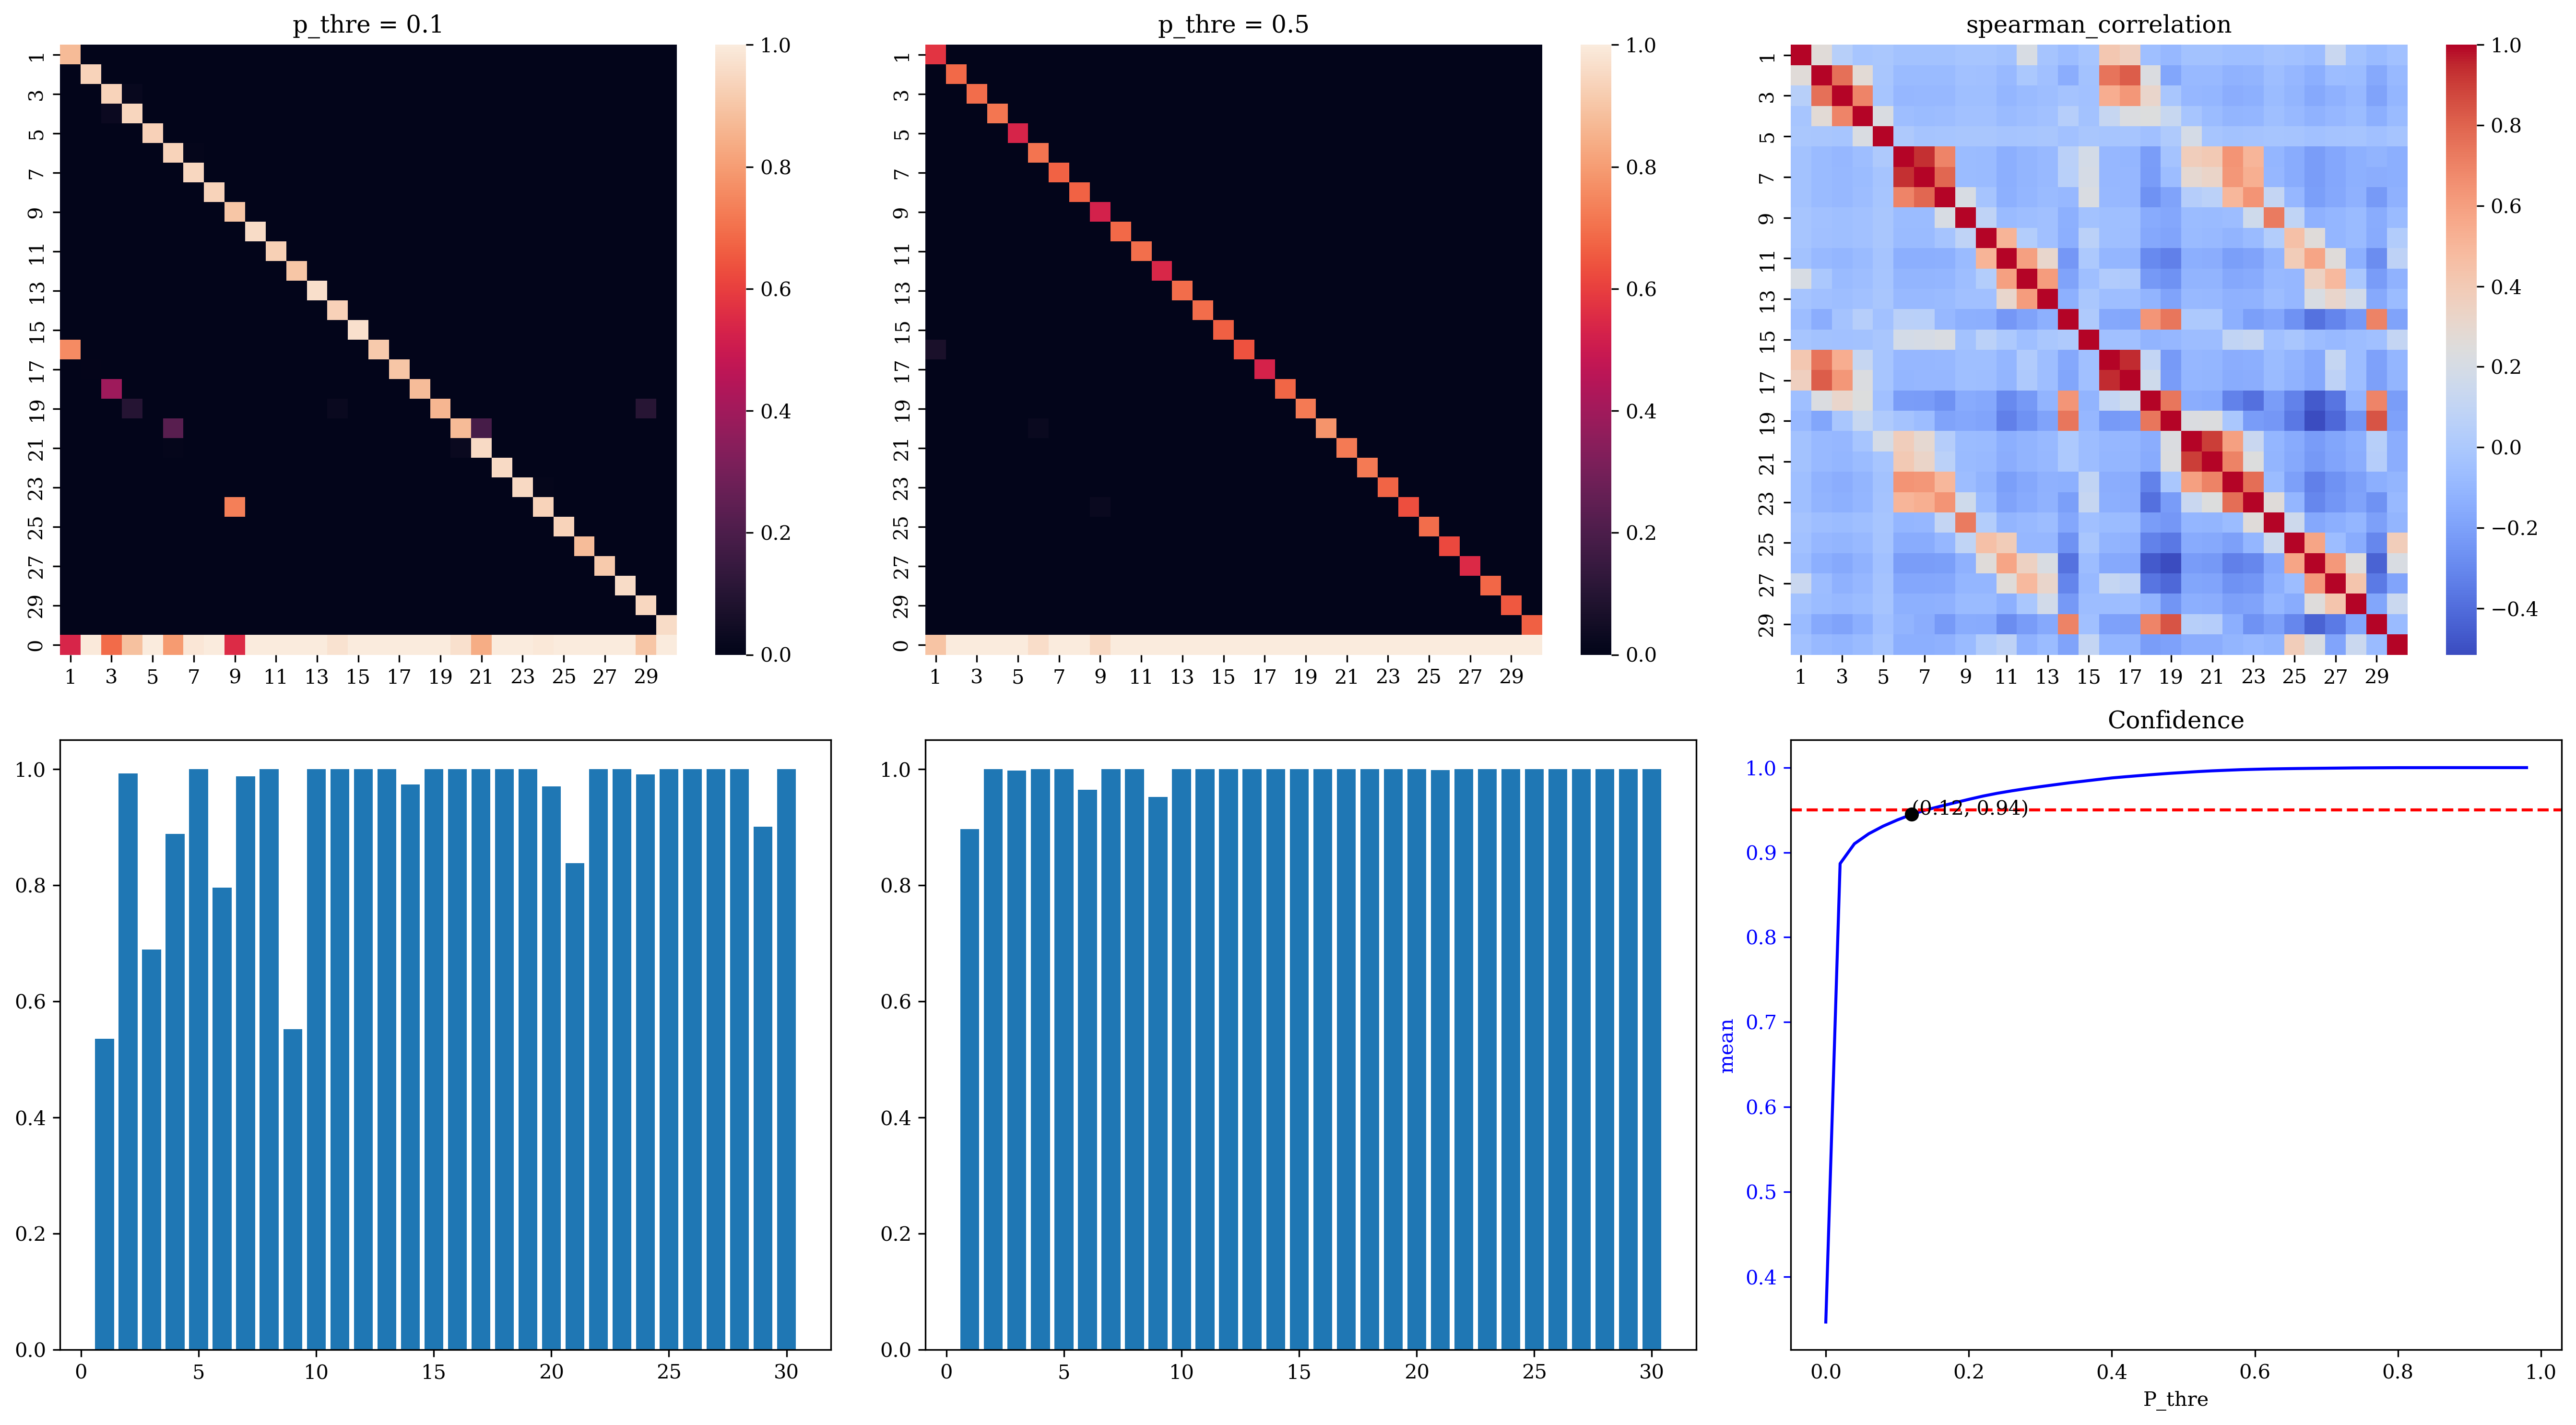

In [89]:
p_thre_list = [0.1, 0.5]
accuracy = []
corr_method = 'spearman'

fig, ax = plt.subplots(nrows=2, ncols=len(p_thre_list) + 1, figsize=(6 * (len(p_thre_list)+1) , 5 * 2))

cdfs_df = cdf_4d.copy()
X_sub = intensity.copy()
ax_heat = ax[0, -1]

corr_matrix = cdfs_df.corr(method=corr_method)
sns.heatmap(corr_matrix, ax=ax_heat, cmap='coolwarm')

ax_heat.set_title(f'{corr_method}_correlation')

for _, p_thre in tqdm(enumerate(p_thre_list), total=len(p_thre_list), desc='p_thre'):
    overlap = pd.DataFrame()

    for cluster_num in range(1, GLAYER*Q_NUM+1):
        tmp = cdfs_df.loc[X_sub['label'][X_sub['label']==(cluster_num)].index]
        overlap[cluster_num] = (tmp>p_thre).sum(axis=0)/len(tmp)
        
    add = np.diag(overlap) / overlap.sum(axis=0)
    ax[1, _].bar(add.index, add.values)
    accuracy.append(np.mean(add))
    overlap = pd.concat([overlap, pd.DataFrame(add).T], axis=0)

    ax_tmp = ax[0, _]
    ax_tmp.set_title(f'p_thre = {p_thre}')

    sns.heatmap(overlap, vmin=0, vmax=1, ax=ax_tmp)


accuracy = plot_mean_accuracy(cdfs_df, X_sub, sample=100, y_line=0.95, total_num=GLAYER*Q_NUM, 
                              out_path=read_dir / 'figures' / 'accuracy.png', ax=ax[-1, -1])
plt.tight_layout()
plt.savefig(figure_dir / 'accuracy.pdf')

# cluster visulization after threshold

## threshold

In [90]:
thre = 0.1

thre_index = []
cdfs_df = cdf_4d.copy()
for cluster_num in range(1, 31):
    tmp = cdf_4d.loc[intensity['label'][intensity['label']==(cluster_num)].index]
    tmp = tmp[tmp[cluster_num]>thre]
    thre_index += list(tmp.index)

thre_index.sort()
thre_index = pd.Index(thre_index)
thre_index = thre_index.unique()

print(f'thre={thre}\tpoints_kept: {len(thre_index) / len(intensity_raw) * 100 :.1f}%')

thre=0.1	points_kept: 81.1%


## visualization of threshold data

100%|██████████| 2/2 [00:01<00:00,  1.73it/s]


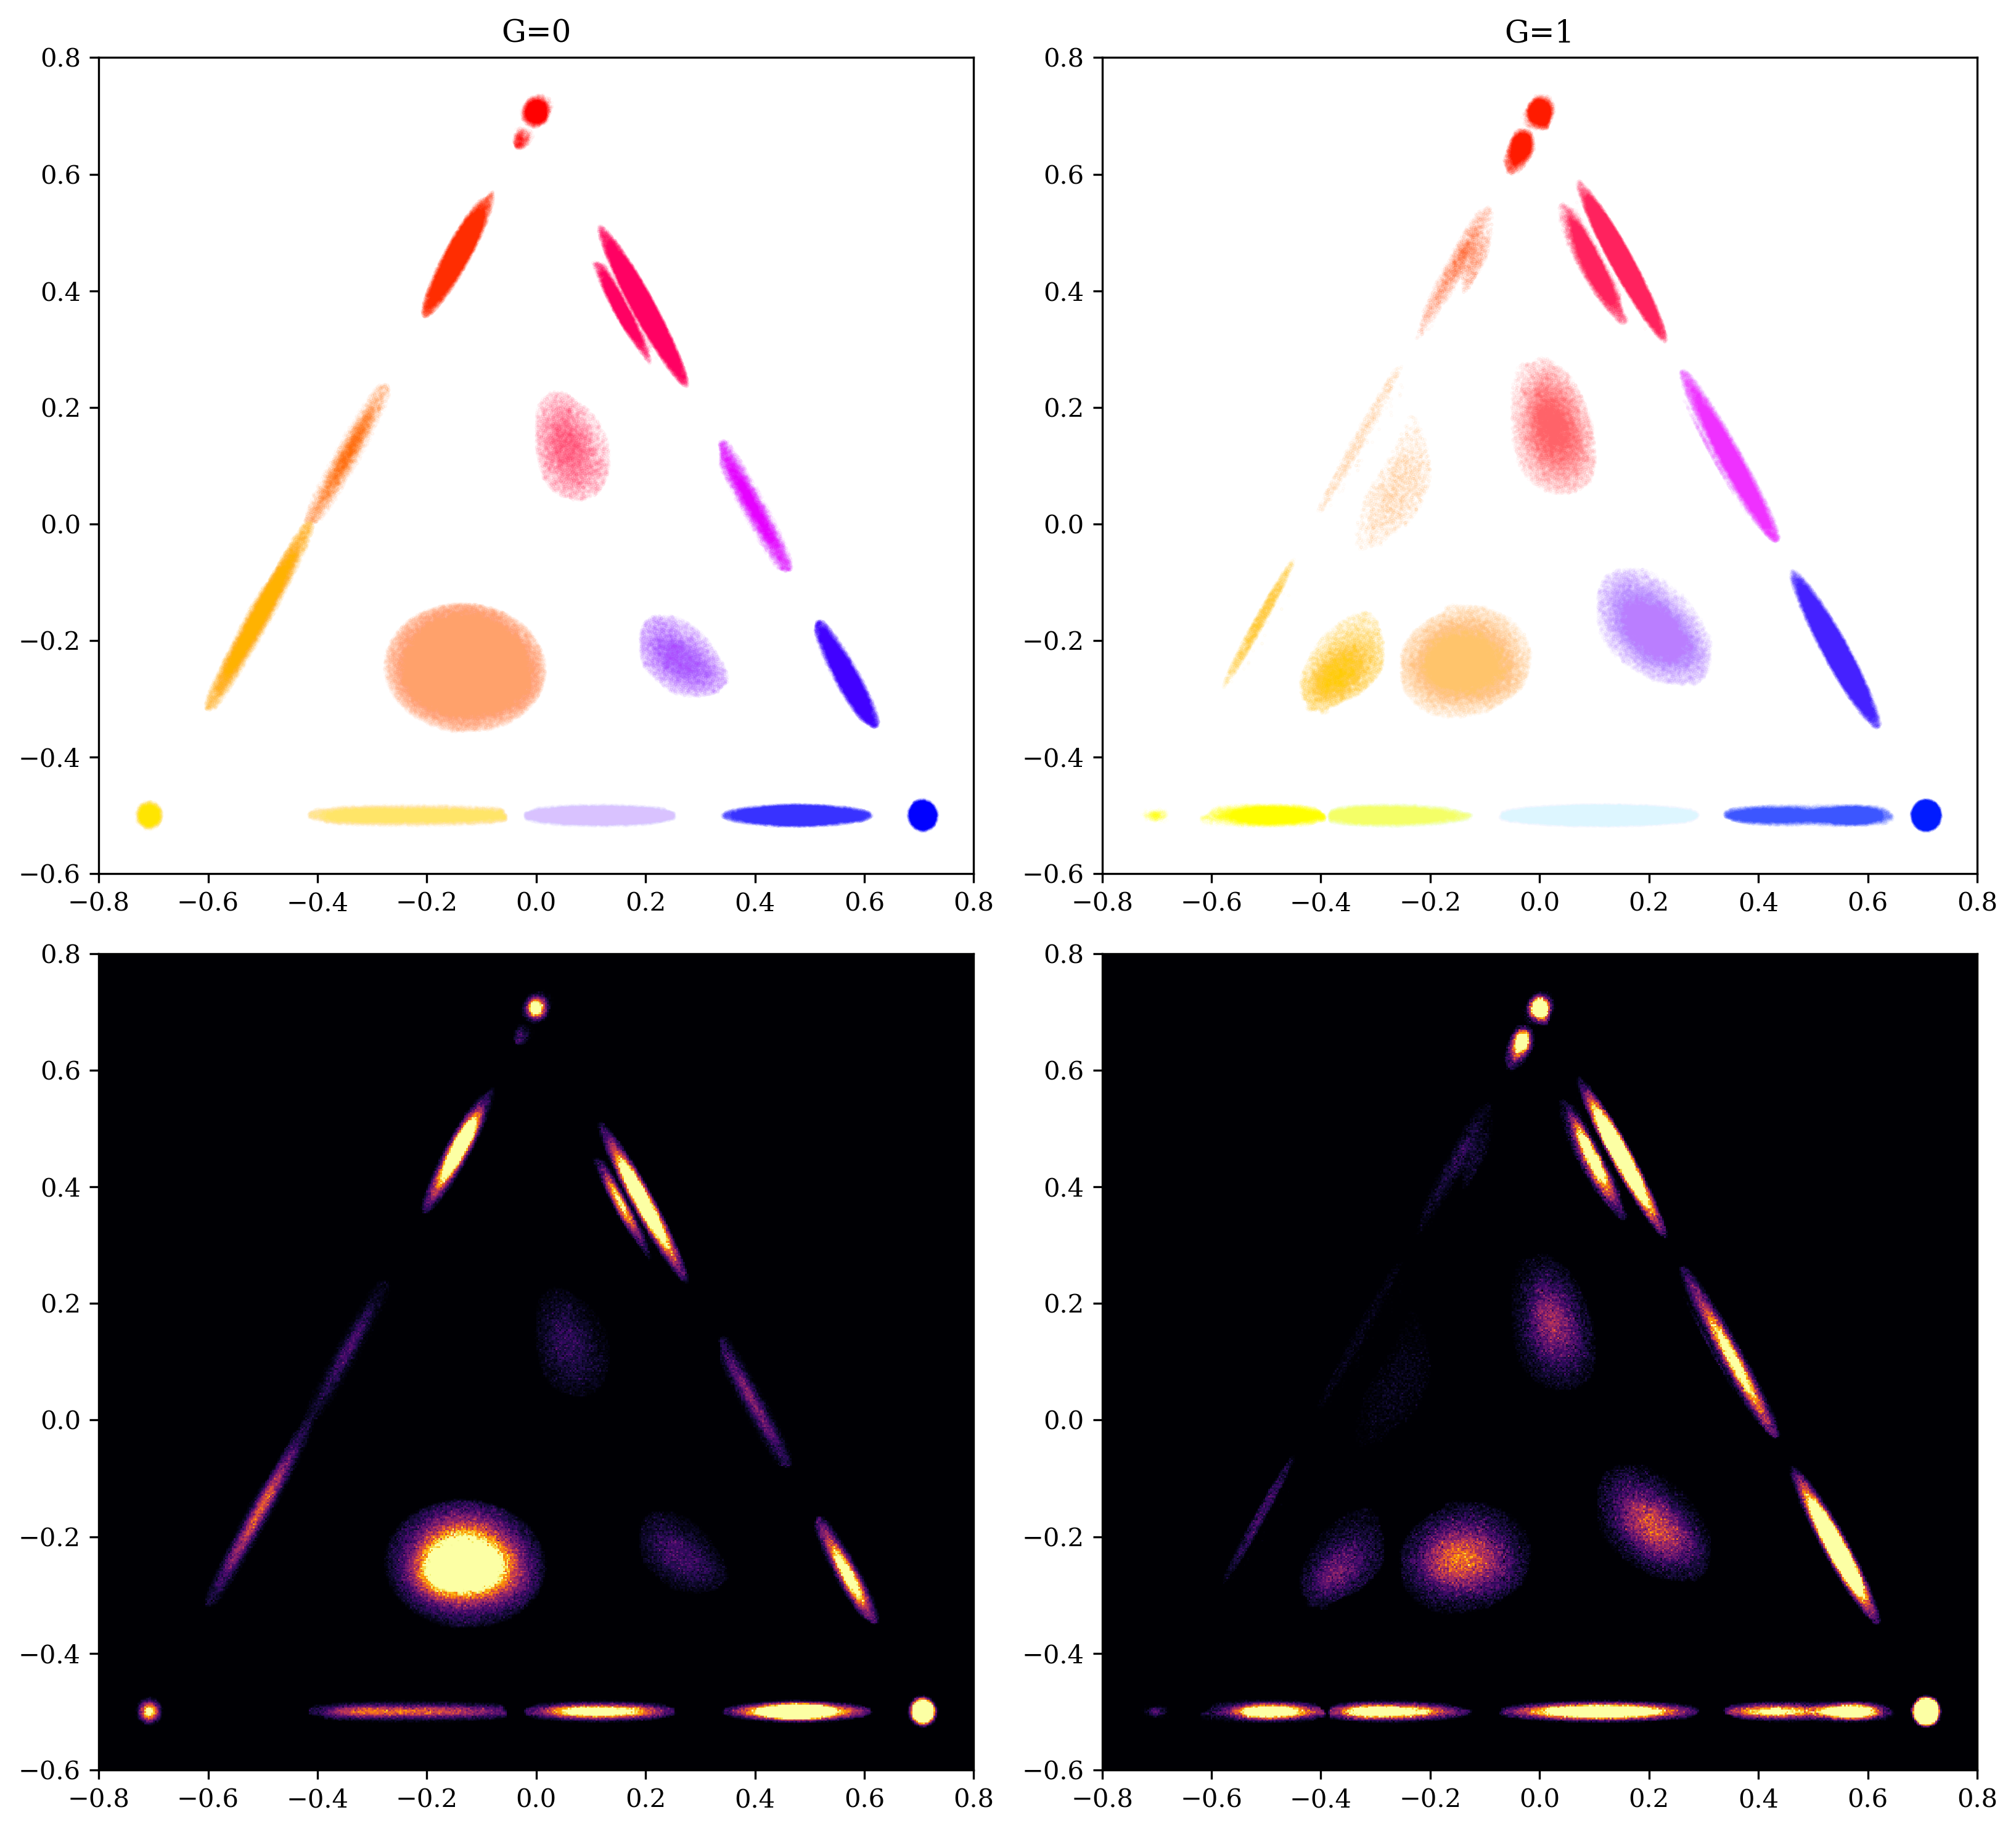

In [91]:
visualization(intensity.loc[thre_index], G_layer=2, num_per_layer=15, 
              colormap_dict=colormap, bins=[500, 500], percentile_thre=99, 
              out_path_dir=figure_dir / 'ColorSpace_selected.png', label=True)

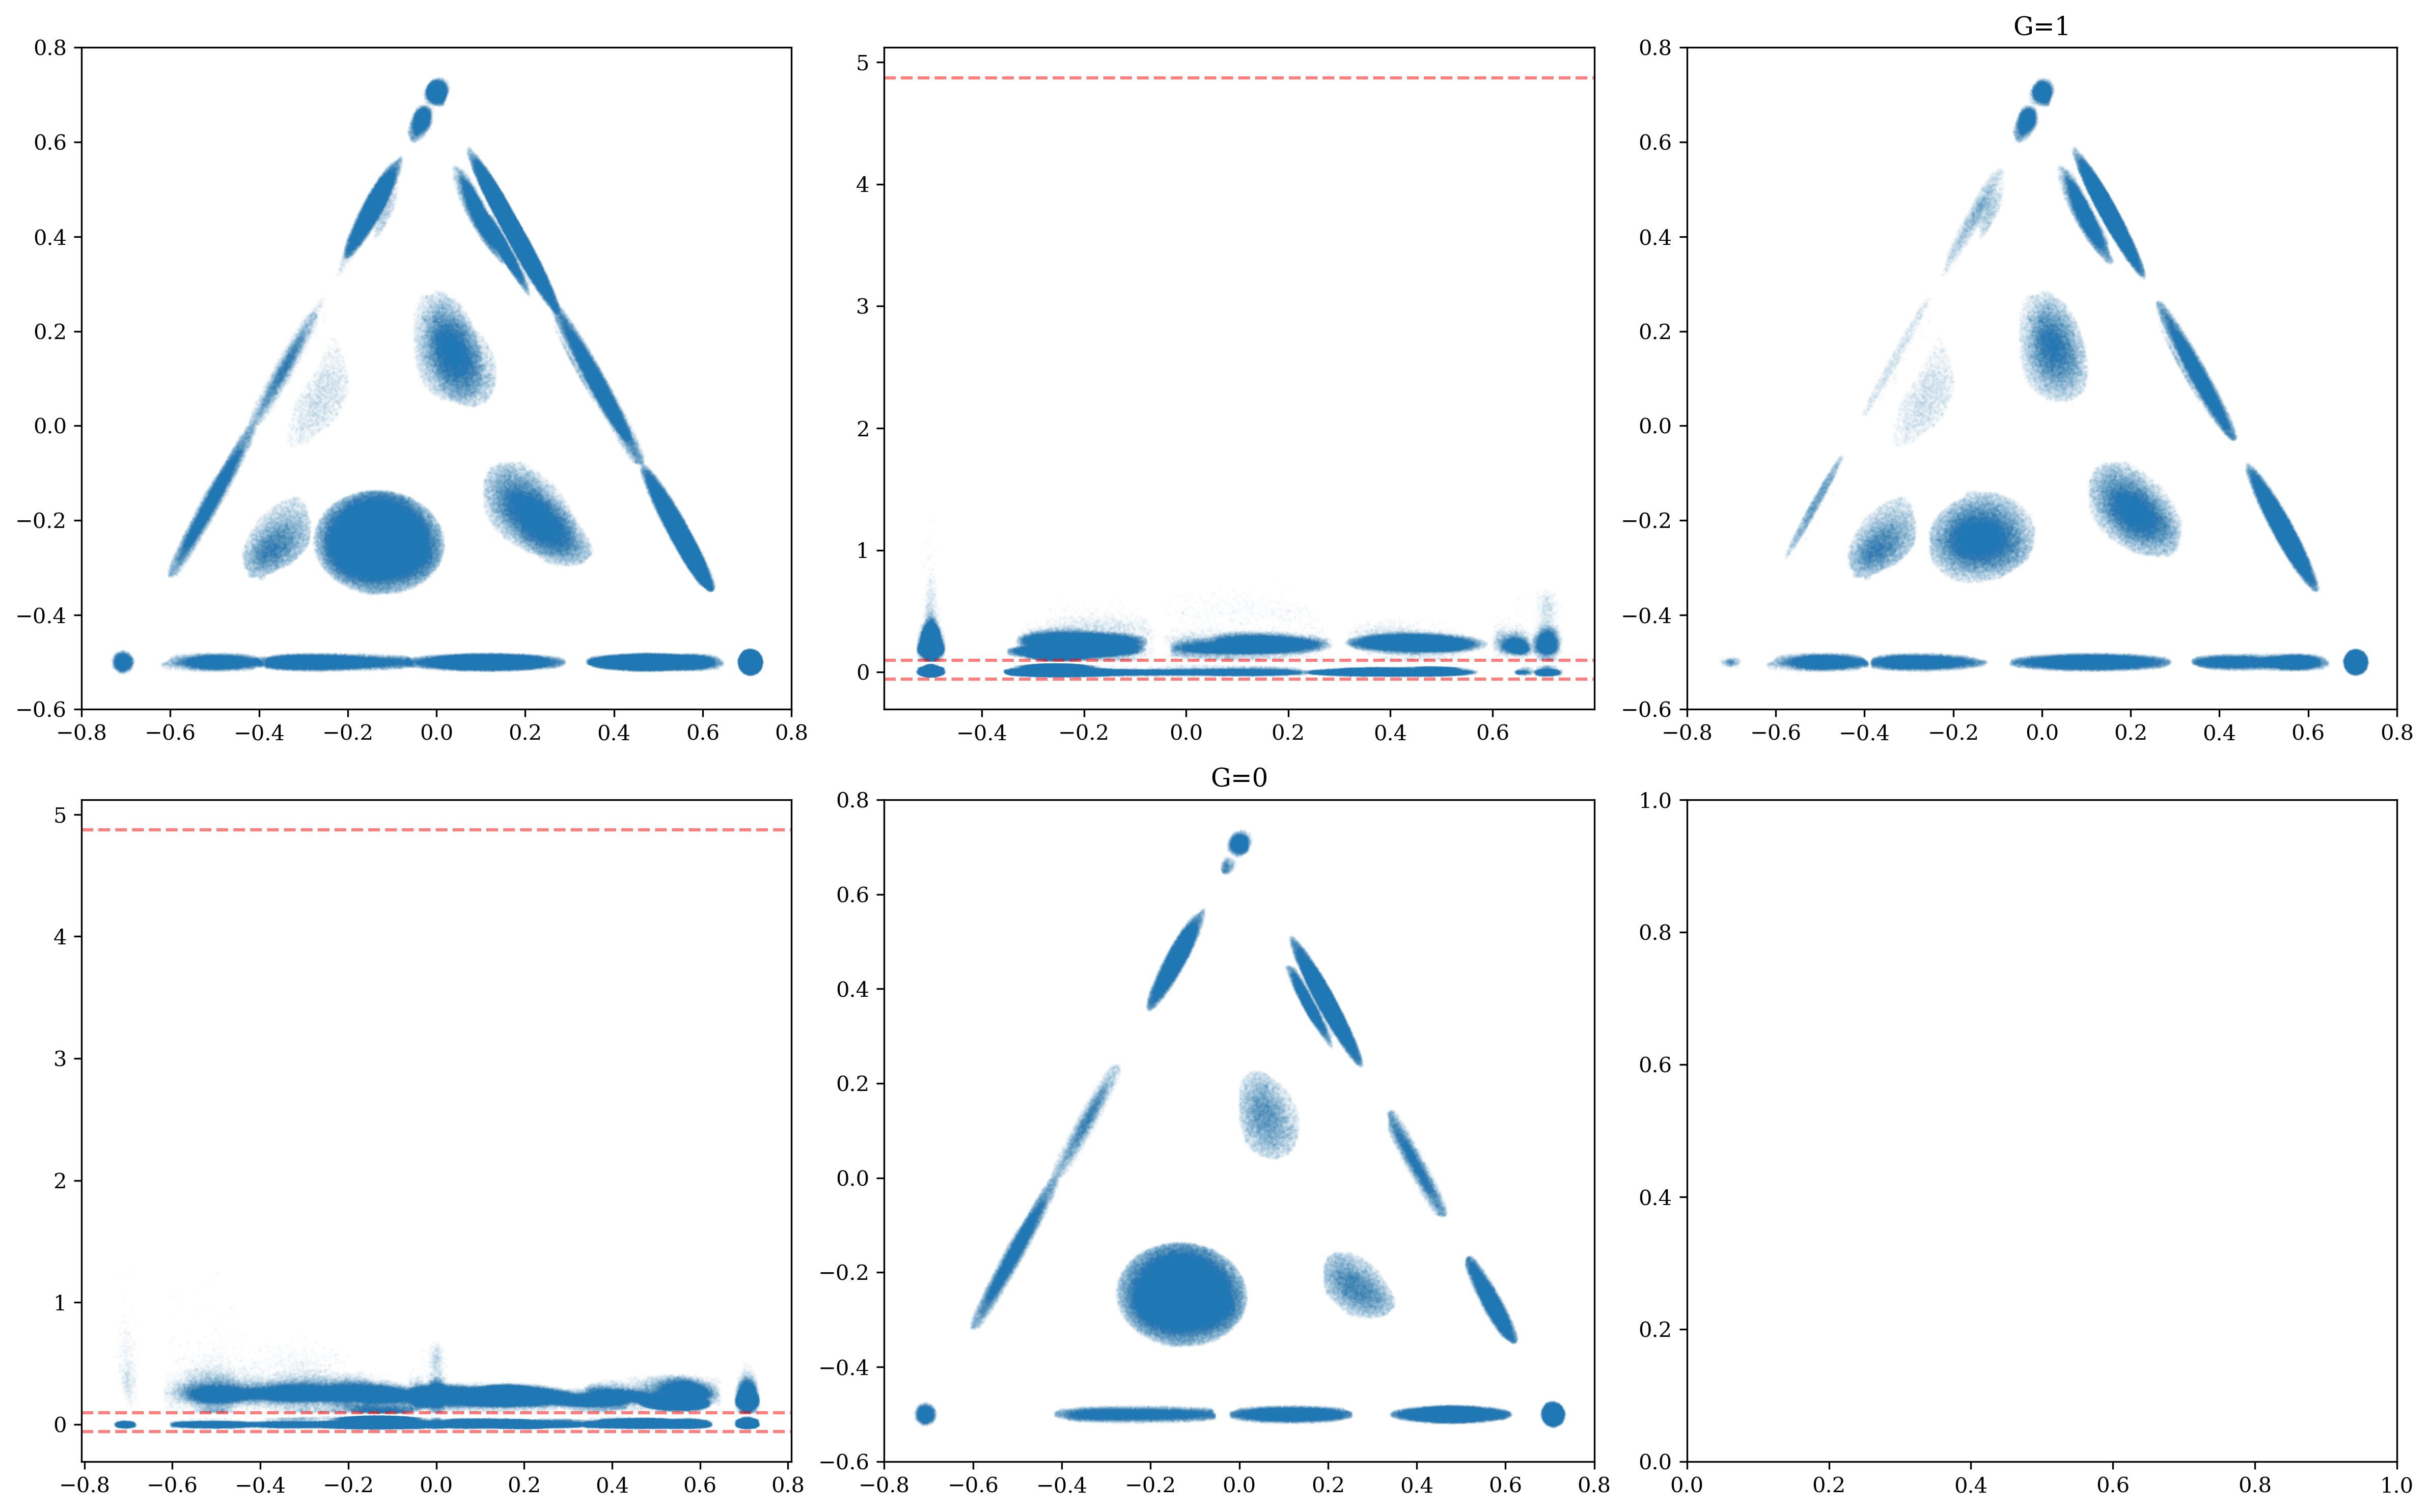

In [92]:
data = intensity.loc[thre_index]

s = 0.01
alpha = 0.1

n_rows = 2
n_cols = 2 - ( - (GLAYER - 1) // 2 )

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5 * n_cols + 1, 10))
ax[1,0].scatter(data['X_coor_gaussian'], data['G/A'], s=s, alpha=alpha, linewidths=None)
ax[0,1].scatter(data['Y_coor_gaussian'], data['G/A'], s=s, alpha=alpha, linewidths=None)
ax[0,0].scatter(data['X_coor_gaussian'], data['Y_coor_gaussian'], s=s, alpha=alpha, linewidths=None)
ax[0,0].set_xlim(XRANGE)
ax[0,0].set_ylim(YRANGE)

for subextrema in minima:
    ax[1,0].axhline(y=subextrema, color='r', alpha=0.5, linestyle='--')
for subextrema in minima:
    ax[0,1].axhline(y=subextrema, color='r', alpha=0.5, linestyle='--')

for layer in range(GLAYER):
    ax_tmp = ax[(1 + layer) % n_rows, 1 - (-layer // n_rows)]
    ax_tmp.set_title(f'G={layer}')
    sub = data[data['G_layer'] == layer]
    ax_tmp.scatter(sub['X_coor_gaussian'], sub['Y_coor_gaussian'], s=s, alpha=alpha, linewidths=None)
    ax_tmp.set_xlim(XRANGE)
    ax_tmp.set_ylim(YRANGE)

plt.tight_layout()
plt.show()

## projection and export to image files

In [94]:
gene_list = [f'PRISM_{i}' for i in range(1, 31)]
data = intensity.loc[thre_index]
mapped_genes = data[['Y', 'X', 'label']]
mapped_genes['Gene'] = mapped_genes['label'].apply(lambda x: gene_list[x-1])
mapped_genes = mapped_genes[['X', 'Y', 'Gene']]
mapped_genes = mapped_genes[(mapped_genes['X']>9500)|(mapped_genes['X']<4000)|
                            (mapped_genes['Y']>29800)|(mapped_genes['Y']<25000)]
mapped_genes

X      Y      Gene
1         16833   8475  PRISM_16
2          8763  17917  PRISM_16
3          8391  15722  PRISM_16
4          8735  15137  PRISM_16
5          8627  20155  PRISM_16
...         ...    ...       ...
15544961  47609  22033  PRISM_16
15546512  60691  31919  PRISM_16
15558179  62463  26653  PRISM_16
15559860  47223  22348  PRISM_16
15571861  57122  22935  PRISM_16

[1561083 rows x 3 columns]

### demo and trial for one

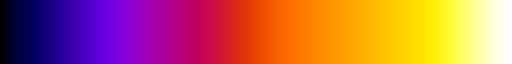

In [96]:
from cmap import Colormap
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# Load the 'fire' colormap using the custom Colormap class
cmap_fire_custom = Colormap('imagej:fire')

# Extract the colors from the custom colormap
percentile = 100
colors = [c for c in cmap_fire_custom.iter_colors()]
colors = [colors[_] for _ in range(len(colors) * percentile // 100)]

# Interpolate colors to create a smoother colormap
def interpolate_colors(colors, num_colors):
    """
    Interpolate a list of colors to create a smoother gradient.
    
    :param colors: List of color tuples.
    :param num_colors: Number of colors in the new colormap.
    :return: List of interpolated color tuples.
    """
    original_indices = np.linspace(0, 1, len(colors))
    new_indices = np.linspace(0, 1, num_colors)
    interpolated_colors = []

    for i in range(3):  # For R, G, B channels
        channel = np.array([c[i] for c in colors])
        interpolated_channel = np.interp(new_indices, original_indices, channel)
        interpolated_colors.append(interpolated_channel)

    return list(zip(interpolated_colors[0], interpolated_colors[1], interpolated_colors[2]))

# Interpolate to create a colormap with 256 colors
num_colors = 256
smooth_colors = interpolate_colors(colors, num_colors)

# Create a new ListedColormap
cmap_fire = ListedColormap(smooth_colors)
cmap_fire

In [97]:
downsample_factor = 100

projection_yrange = mapped_genes['Y'].min() - 2000, mapped_genes['Y'].max() + 2000 
projection_xrange = mapped_genes['X'].min() - 2000, mapped_genes['X'].max() + 2000
bins = ((projection_xrange[1] - projection_xrange[0]) // downsample_factor, 
        (projection_yrange[1] - projection_yrange[0]) // downsample_factor)
figsize = (10.5, bins[1] / bins[0] * 10)

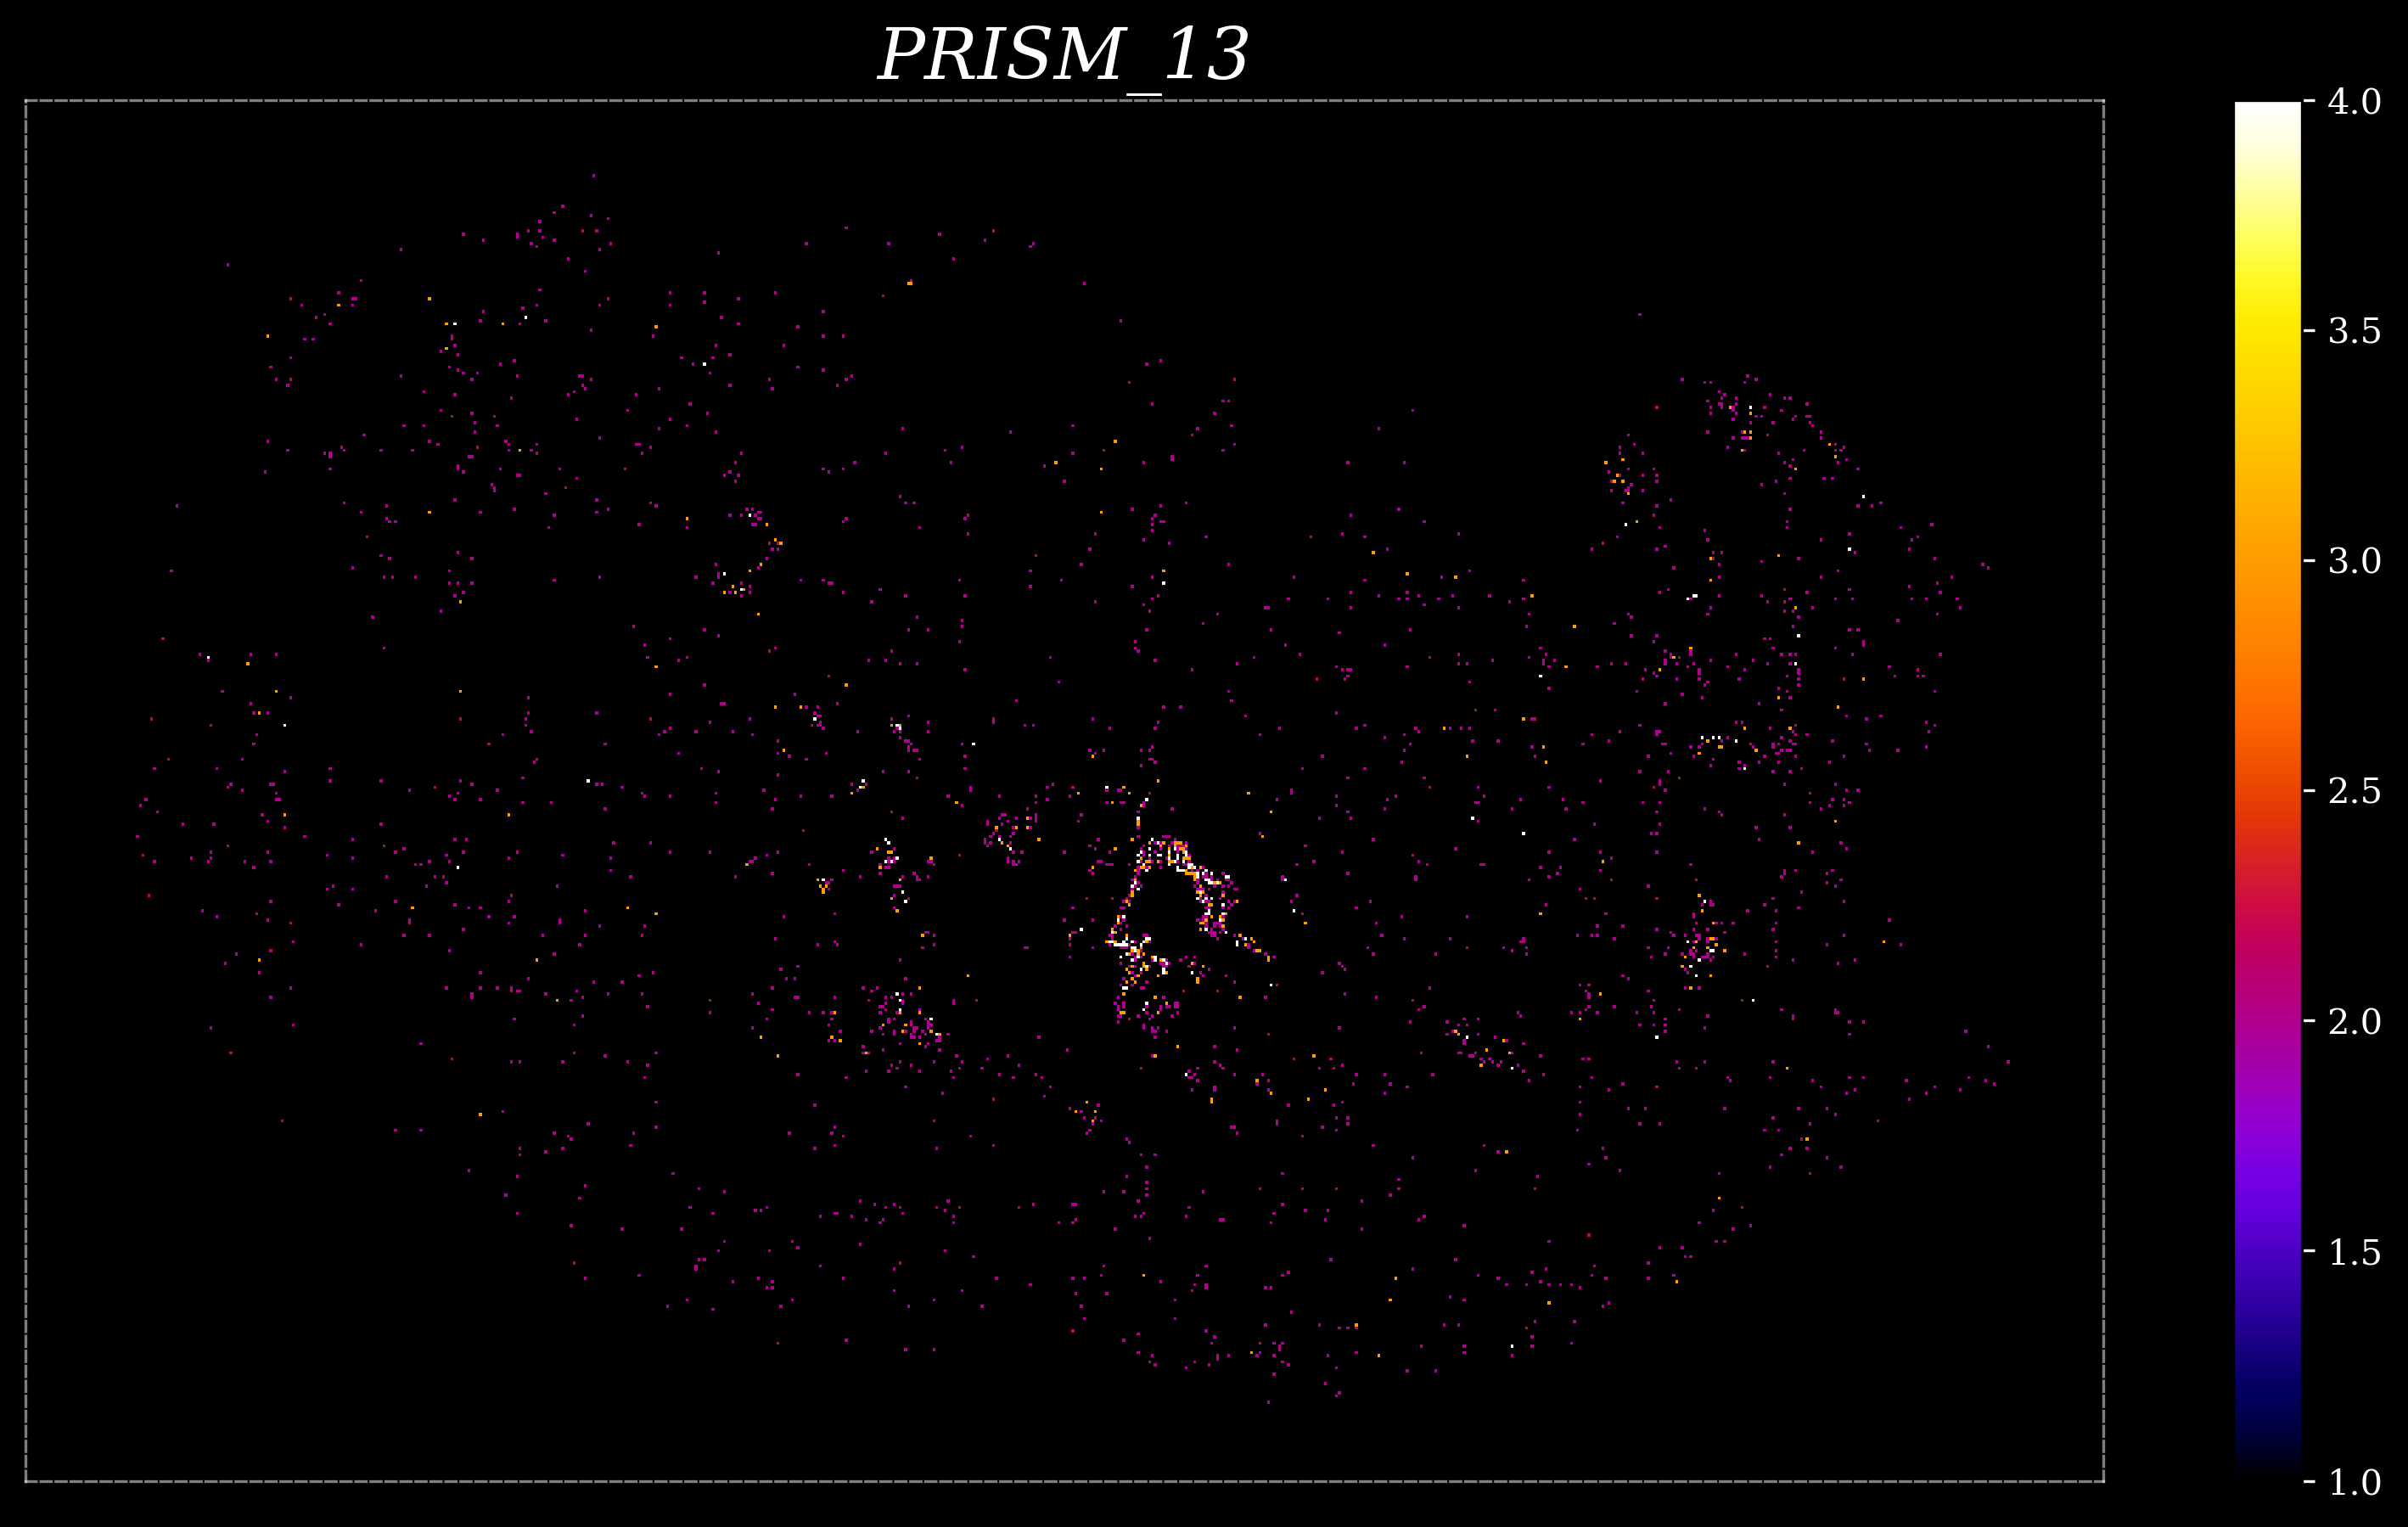

In [108]:
gene_order=13
gene_name = gene_list[gene_order-1]
points = mapped_genes[mapped_genes['Gene']==gene_name][['X', 'Y']].values

x = points[:, 0]
y = points[:, 1]

def projection_gene(x, y, bins=bins, outpath=None):
    # Creating the 2D histogram
    hist, xedges, yedges = np.histogram2d(x, y, bins=bins)
    percentile_max = np.percentile(hist, 99.98)
    percentile_min = min(max(1, np.percentile(hist, 90)), percentile_max // 4)

    fig, ax = plt.subplots(figsize=figsize)
    fig.patch.set_facecolor('black')
    plt.hist2d(x, y, 
                range=[projection_xrange, projection_yrange],
                bins=bins, 
                vmax=percentile_max,
                vmin=percentile_min,
                cmap=cmap_fire,
                )

    cbar = plt.colorbar()

    cbar.ax.yaxis.set_tick_params(color='white')
    cbar.ax.yaxis.set_tick_params(labelcolor='white')

    plt.title(f'{gene_name.upper()}', fontsize=20, fontstyle='italic')

    ax.set_facecolor('black')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.title.set_color('white')
    ax.set_xlabel('')
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_ylabel('')
    ax.set_yticks([])
    ax.set_yticklabels([])

    for spine in ax.spines.values():
        spine.set_edgecolor('white')
        spine.set_linestyle('--')
        spine.set_alpha(0.5)

    ax.tick_params(colors='white', which='both')  # 'both' means both major and minor ticks are affected
    plt.tight_layout()
    if outpath is None: plt.show()
    else: plt.savefig(os.path.join(outpath, f'PRISM{gene_order}_{gene_name}.png'), dpi=300, bbox_inches='tight')
    plt.close()
        
projection_gene(x=x, y=y, bins=bins)

### batch export 

#### use 2d hist and export to png files

In [109]:
out_path = read_dir / 'density'
os.makedirs(out_path, exist_ok=True)

for gene_order in tqdm(range(1,31)):
  gene_name = gene_list[gene_order-1]
  points = mapped_genes[mapped_genes['Gene']==gene_name][['X', 'Y']].values

  # Extracting x and y coordinates
  x = points[:, 0]
  y = points[:, 1]

  projection_gene(x, y, outpath=out_path)

100%|██████████| 30/30 [00:19<00:00,  1.50it/s]


In [110]:
mapped_genes[['Y', 'X', 'Gene']].to_csv(read_dir / 'mapped_genes.csv')

# visualization of rays

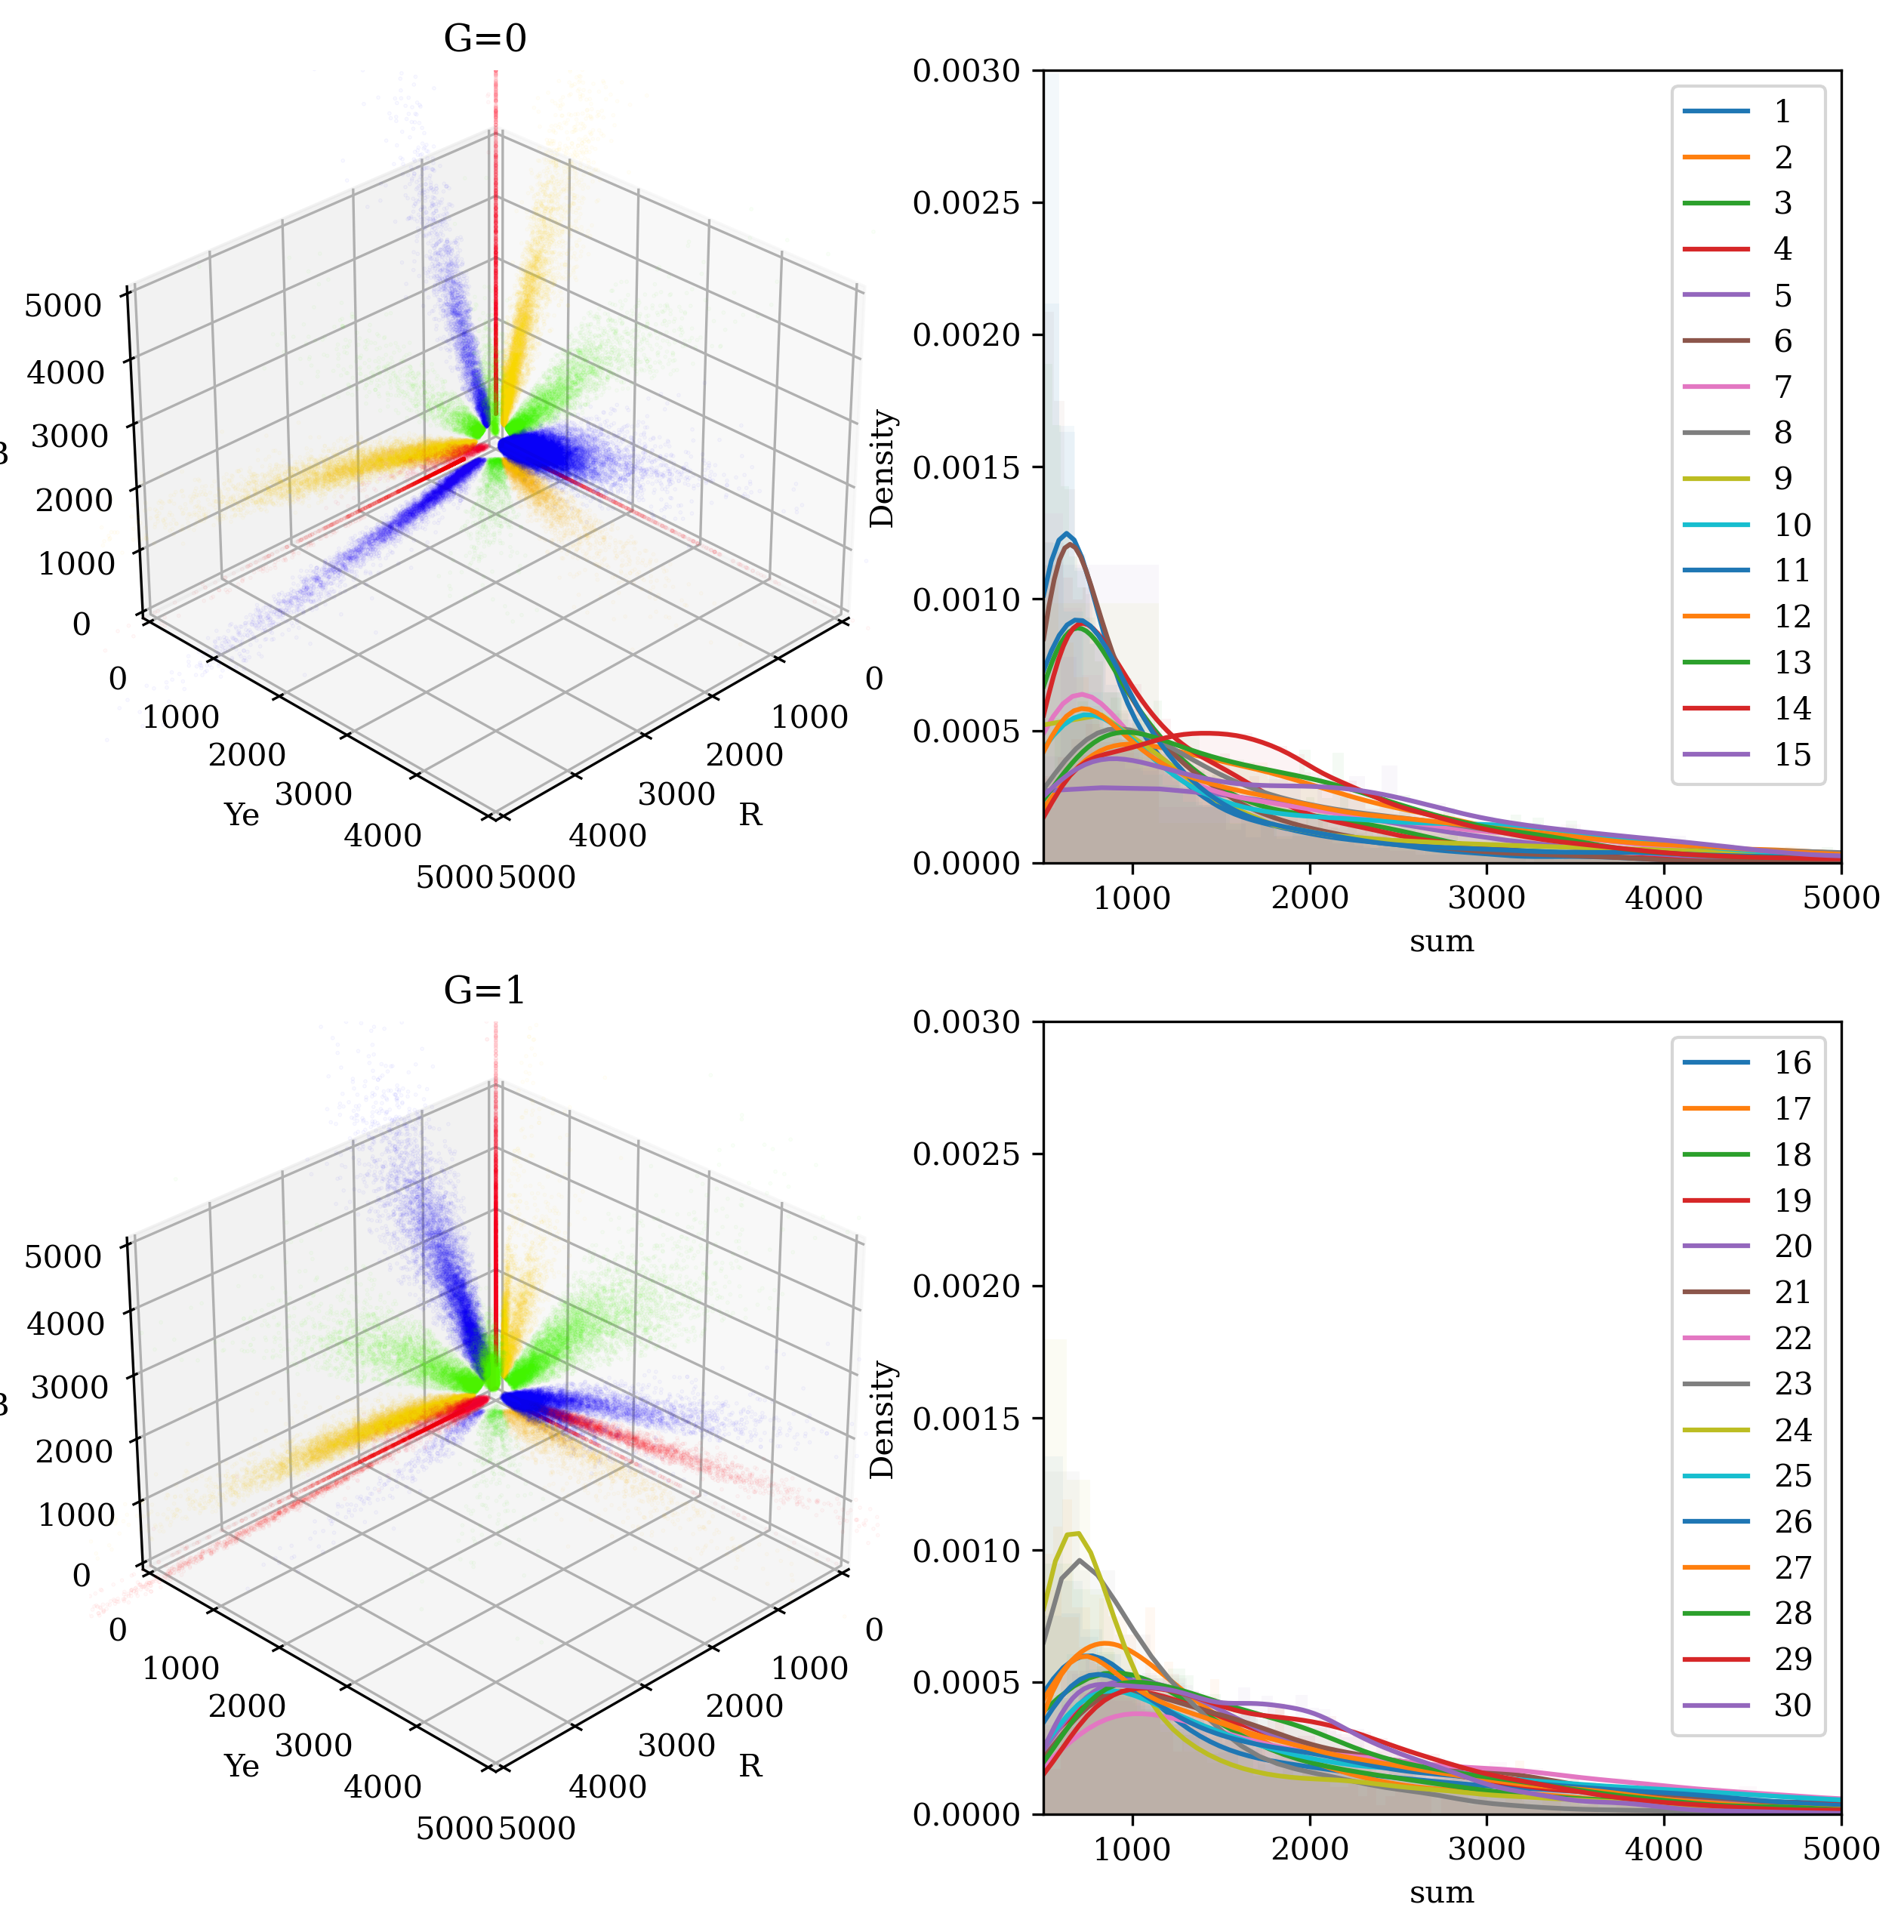

In [132]:
# GLAYER = 2
fig = plt.figure(figsize=(10, GLAYER*5))
for i in range(GLAYER):
    tmp = intensity[intensity['G_layer']==i].sample(100000)
    x = tmp['R']
    y = tmp['Ye']
    z = tmp['B']
    
    # 创建3D散点图
    ax1 = fig.add_subplot(GLAYER, 2, 2*i+1, projection='3d')
    scatter = ax1.scatter(x, y, z, c=tmp['label'], alpha=0.05, s=0.1, cmap='prism')
    ax1.set_xlabel('R')
    ax1.set_ylabel('Ye')
    ax1.set_zlabel('B')
    ax1.view_init(30, 45)
    ax1.set_xlim([0, 5000])
    ax1.set_ylim([0, 5000])
    ax1.set_zlim([0, 5000])
    ax1.set_title(f'G={i}')

    # 为第二位的子图设置直方图
    ax2 = fig.add_subplot(GLAYER, 2, 2*i+2)
    for label in np.unique(tmp['label']): 
        sns.histplot(tmp[tmp['label']==label]['sum'], bins=100, alpha=0.05, kde=True, stat='density', edgecolor=None, ax=ax2)
    ax2.set_xlim([500, 5000])
    ax2.set_ylim([0, 0.003])
    ax2.legend(np.unique(tmp['label']))

# plt.tight_layout()
plt.savefig(figure_dir / 'ColorSpace_3d_and_sum_evaluation.png', bbox_inches='tight', dpi=300)
plt.show()

# legacy

### cdf-3d and separate by layer

In [ ]:
# CDF_dict = dict()
# for layer in range(GLAYER):
#     X = intensity[intensity['G_layer'] == layer]
#     X_sub = X.copy()
#     CDF_dict[layer] = calculate_cdf_gmm(X_sub, GMM_dict[layer], st=layer * Q_NUM)

In [ ]:
# data = intensity[intensity['label'] != -1]
# CDF_dict = dict()
# for layer in range(GLAYER):
#     CDF_dict[layer]= calculate_cdf_mannual(data, st=layer * Q_NUM, num_per_layer=Q_NUM)

#### cdf distribution overall

In [ ]:
# for layer in range(GLAYER):
#    cdf_data = CDF_dict[layer]
#    ax_tmp = ax if GLAYER < 2 else ax[layer]
#    cm = sns.clustermap(cdf_data.sample(1000), figsize=(5, 4), metric='euclidean',
#                      method='ward', 
#                      col_cluster=False,
#                      )
#    cm.ax_heatmap.set(yticks=[],)
#    cm.fig.suptitle(f'layer={layer}')

#### cluster relationship evaluation by heatmap

In [ ]:
# p_thre_list = [0.0001, 0.001, 0.01, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5]
# corr_method = 'spearman'

# fig, ax = plt.subplots(nrows=GLAYER, ncols=len(p_thre_list) + 1, figsize=(6 * (len(p_thre_list)+1) , 5 * GLAYER))
# for layer in tqdm(range(GLAYER)):
#     cdfs_df = CDF_dict[layer]
#     X_sub = intensity[intensity['G_layer'] == layer]
#     ax_heat = ax[layer, -1] if GLAYER > 1 else ax[-1]
    
#     corr_matrix = cdfs_df.corr(method=corr_method)
#     sns.heatmap(corr_matrix, 
#                 ax=ax_heat, 
#                 cmap='coolwarm',
#                 )
    
#     ax_heat.set_title(f'{corr_method}_correlation')

#     for _, p_thre in enumerate(p_thre_list):
#         overlap = pd.DataFrame()

#         for cluster_num in range(layer * Q_NUM + 1, (layer + 1) * Q_NUM + 1):
#             tmp = cdfs_df.loc[X_sub['label'][X_sub['label']==(cluster_num)].index]
#             overlap[cluster_num] = (tmp>p_thre).sum(axis=0)/len(tmp)

#         ax_tmp = ax[layer, _] if len(p_thre_list) > 1 and GLAYER > 1 else ax[layer] if GLAYER > 1 else ax[_] if len(p_thre_list) > 1 else ax
#         ax_tmp.set_title(f'p_thre = {p_thre}')
#         if _ == 0:
#             ax_tmp.set_ylabel(f'G={layer}', fontsize=16)

#         sns.heatmap(overlap, vmin=0, vmax=1, ax=ax_tmp)

# plt.tight_layout()
# plt.show()

#### overall separation evaluation by entropy

In [ ]:
# from sklearn.metrics import silhouette_score
# from sklearn.metrics import calinski_harabasz_score
# from sklearn.metrics import davies_bouldin_score
# from scipy.stats import entropy


# sample=20
# p_thre_list = [_/sample for _ in range(sample)]
# # p_thre_list = [0.1]
# near_list = []
# en_list = []

# data = intensity.copy()

# for thre in tqdm(p_thre_list):
#     thre_index = []
#     for layer in range(GLAYER):
#         cdfs_df = CDF_dict[layer]
#         X_sub = data[data['G_layer'] == layer]
#         for cluster_num in range(layer*Q_NUM+1, (layer+1)*Q_NUM+1):
#             tmp = cdfs_df.loc[X_sub['label'][X_sub['label']==(cluster_num)].index]
#             tmp = tmp[tmp[cluster_num]>thre]
#             thre_index += list(tmp.index)

#     thre_index.sort()
#     thre_index = pd.Index(thre_index)
#     tmp1 = intensity.loc[thre_index]
    

#     score = []
#     en  = []
#     for layer in range(GLAYER):
#         cdfs_df = CDF_dict[layer]
#         tmp = tmp1[tmp1['G_layer']==layer]
#         tmp_index = tmp.index
#         tmp_cdf = cdfs_df.loc[tmp_index].sample(min(20000, len(tmp_index)))
#         tmp_cdf_sum = tmp_cdf.sum(axis=1)
#         tmp_cdf_cal = tmp_cdf.div(tmp_cdf_sum, axis=0)

#         score.append(davies_bouldin_score(tmp[Q_CHANNELS], tmp['label']))
#         en.append(np.mean([entropy(tmp_cdf_cal.iloc[i]) / np.log(Q_NUM) / np.sqrt(tmp_cdf_sum.iloc[i]) for i in range(len(tmp_cdf_cal))]))
    
#     en_list.append(en)
#     near_list.append(score)

# near_list = np.array(near_list)
# en_list = np.array(en_list)

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Create data
# p_thre_list = [_/sample for _ in range(sample)]
# x = p_thre_list
# y1 = en_list[:,0]  # Data for the first y-axis
# y2 = en_list[:,1]  # Data for the second y-axis
# # y3 = en_list[:,2]  # Data for the second y-axis

# # Create a figure and a primary axes
# fig, ax1 = plt.subplots()

# # Plot the first dataset on primary axes
# ax1.plot(x, y1, 'b-')
# ax1.set_xlabel('P_thre')
# ax1.set_ylabel('Entropy_0', color='b')
# ax1.tick_params('y', colors='b')

# # Create and plot on the secondary axes
# ax2 = ax1.twinx()
# ax2.plot(x, y2, 'r-')
# ax2.set_ylabel('Entropy_1', color='r')
# ax2.tick_params('y', colors='r')

# # Create and plot on the third axes
# # ax3 = ax1.twinx()
# # ax3.spines['right'].set_position(('outward', 60))  # Offset the right spine
# # ax3.plot(x, y3, 'g-')
# # ax3.set_ylabel('Entropy_2', color='g')
# # ax3.tick_params('y', colors='g')

# plt.title("Entropy")
# plt.show()


## entropy evaluation

#### entropy evaluation

In [ ]:
# from sklearn.metrics import silhouette_score
# from sklearn.metrics import calinski_harabasz_score
# from sklearn.metrics import davies_bouldin_score
# from scipy.stats import entropy


# tmp_channel = ['Ye/A', 'B/A', 'R/A', 'G/A']

# tick = 20
# p_thre_list_4d = [0.01+_/tick for _ in range(tick)]
# # p_thre_list = [0.1]

# score_4d = []
# entropy_detail = []

# for thre in tqdm(p_thre_list_4d):
#     thre_index = []
#     data = intensity.copy()
#     cdfs_df = cdf_4d.copy()
#     for cluster_num in range(1, total_num+1):
#         tmp = cdfs_df.loc[data['label'][data['label']==(cluster_num)].index]
#         tmp = tmp[tmp[cluster_num]>thre]
#         thre_index += list(tmp.index)

#     thre_index.sort()
#     thre_index = pd.Index(thre_index)
#     tmp = intensity.loc[thre_index]
#     tmp_cdf = cdfs_df.loc[thre_index].sample(min(20000, len(thre_index)))
#     tmp_cdf_sum = tmp_cdf.sum(axis=1)
#     tmp_cdf_cal = tmp_cdf.div(tmp_cdf_sum, axis=0)

#     entropy_list = [entropy(tmp_cdf_cal.iloc[i]) / np.log(63) / tmp_cdf_sum.iloc[i] for i in range(len(tmp_cdf_cal))]
#     score_4d.append(davies_bouldin_score(tmp[tmp_channel], tmp['label'])) 
#     entropy_detail.append(entropy_list)
# score_4d = np.array(score_4d)

In [ ]:
# import matplotlib.pyplot as plt

# # Sample data
# x = p_thre_list_4d
# # y1 = en_4d  # Data for the first y-axis
# # y2 = score_4d  # Data for the second y-axis
# # y3 = [np.percentile(np.array(sorted(entropy_detail[_])), 99) for _ in range(len(entropy_detail))]
# y1 = [np.percentile(entropy_detail[_], 100) for _ in range(len(entropy_detail))]
# y2 = [np.percentile(entropy_detail[_], 99) for _ in range(len(entropy_detail))]
# y3 = [np.percentile(entropy_detail[_], 95) for _ in range(len(entropy_detail))]
# y4 = [np.percentile(entropy_detail[_], 90) for _ in range(len(entropy_detail))]
# y5 = [np.mean(entropy_detail[_]) for _ in range(len(entropy_detail))]


# # Create a figure and a set of subplots
# fig, ax1 = plt.subplots()

# # Plot the first line
# color = 'tab:red'
# ax1.set_xlabel('p_thre')
# ax1.set_ylabel('Entropy_max', color=color)
# ax1.plot(x, y1, color=color)
# ax1.tick_params(axis='y', labelcolor=color)

# # Instantiate a second y-axis sharing the same x-axis
# ax2 = ax1.twinx()  
# color = 'orange'
# ax2.set_ylabel('Entropy_0.99', color=color)
# ax2.plot(x, y2, color=color)
# ax2.tick_params(axis='y', labelcolor=color)

# # Create and plot on the third axes
# ax3 = ax1.twinx()
# ax3.spines['right'].set_position(('outward', 60))  # Offset the right spine
# ax3.plot(x, y3, 'g-')
# ax3.set_ylabel('Entropy_0.95', color='g')
# ax3.tick_params('y', colors='g')

# # Create and plot on the third axes
# ax4 = ax1.twinx()
# color = 'tab:blue'
# ax4.spines['right'].set_position(('outward', 120))  # Offset the right spine
# ax4.plot(x, y4, color=color)
# ax4.set_ylabel('Entropy_0.90', color=color)
# ax4.tick_params(axis='y', labelcolor=color)

# # Create and plot on the third axes
# ax4 = ax1.twinx()
# color = 'purple'
# ax4.spines['right'].set_position(('outward', 180))  # Offset the right spine
# ax4.plot(x, y5, color=color)
# ax4.set_ylabel('Entropy_mean', color=color)
# ax4.tick_params(axis='y', labelcolor=color)

# # Show the plot
# plt.title('Quality by p_thre')
# plt.show()

#### entropy evaluation by simulation data

In [ ]:
# centroids_si = []
# color_maxima = [_/(COLOR_GRADE-1) for _ in range(COLOR_GRADE)]
# color_tmp = [_/COLOR_GRADE for _ in range(COLOR_GRADE)]
# for layer in range(3):
#     combinations = itertools.product(range(0, COLOR_GRADE), repeat=3)
#     filtered_combinations = filter(lambda x: sum(x) == COLOR_GRADE - 1, combinations)
#     centroids_si += [[color_maxima[_[0]], color_maxima[_[1]], color_maxima[_[2]], 0.8*layer/(GLAYER-1)] for _ in filtered_combinations]

In [ ]:
# def generate_gaussian(centroids, cov, channel, sample=1000):
#     """
#     generate random points of the same dimension of centroids in several
#     gaussian distributions(the distribution number is the same as the number of centroids)
#     at the centroids with covariance matrix cov, and points of one distribution is marked.
#     """
#     intensity_simu = pd.DataFrame()
#     for _, centroid in enumerate(centroids):
#         # generate random points of the same dimension of centroids
#         points = np.random.multivariate_normal(centroid, cov, sample)
#         label = np.array([[int(_+1)] for j in range(sample)])
#         add_data = np.concatenate([points, label], axis=1)
#         add_df = pd.DataFrame(data=add_data, columns=channel+['label'])
#         intensity_simu = pd.concat([intensity_simu, add_df])
#     return intensity_simu

In [ ]:
# intensity_simu = generate_gaussian(centroids=centroids_si, cov=np.diag([0.002]*3+[0.005]), channel=['Ye/A', 'B/A', 'R/A', 'G/A'], sample=1000)
# intensity_simu['X_coor_gaussian'] = intensity_simu[Q_CHANNELS].dot(RYB_x_transform)
# intensity_simu['Y_coor_gaussian'] = intensity_simu[Q_CHANNELS].dot(RYB_y_transform)
# intensity_simu.index = [_ for _ in range(len(intensity_simu))]

In [ ]:
# from scipy import stats

# data = intensity_simu.copy()
# data = data.sample(5000)

# x = np.array(data['X_coor_gaussian'])
# y = np.array(data['Y_coor_gaussian'])
# z = np.array(data['G/A'])
# xyz = np.vstack([x,y,z])
# density = stats.gaussian_kde(xyz)(xyz) 

# idx = density.argsort()
# x, y, z, density = x[idx], y[idx], z[idx], density[idx]
# fig = plt.figure(figsize=(7, 7))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(x, y, z, 
#            c=density, 
#            cmap=plt.cm.gnuplot2 ,
#            s=0.1,
#            vmin=0,
#           #  vmax=1,
#            ) 
# ax.set_zlim3d(-0.1,1)
# ax.view_init(elev=90, azim=30)

# fig.set_facecolor('black')
# ax.set_facecolor('black') 
# ax.grid(False) 
# ax.w_xaxis.pane.fill = False
# ax.w_yaxis.pane.fill = False
# ax.w_zaxis.pane.fill = False
# ax.set_axis_off()

In [ ]:
# total_num = 63
# cdf_simu = calculate_cdf_mannual(intensity_simu, st=0, num_per_layer=total_num, channel=['Ye/A', 'B/A', 'R/A', 'G/A'])

# cdfs_df = cdf_simu.copy()
# X_sub = intensity_simu.copy()
# corr_method = 'spearman'
# p_thre_list = [0.0001, 0.001, 0.01, 0.1,]

# fig, ax = plt.subplots(nrows=1, ncols=len(p_thre_list) + 1, figsize=(6 * (len(p_thre_list)+1) , 5 * 1))

# ax_heat = ax[-1]
# corr_matrix = cdfs_df.corr(method=corr_method)
# sns.heatmap(corr_matrix,ax=ax_heat, cmap='coolwarm')
# ax_heat.set_title(f'{corr_method}_correlation')

# for _, p_thre in tqdm(enumerate(p_thre_list), desc='p_thre'):
#     overlap = pd.DataFrame()
#     for cluster_num in range(1, total_num+1):
#         tmp = cdfs_df.loc[X_sub['label'][X_sub['label']==(cluster_num)].index]
#         overlap[cluster_num] = (tmp>p_thre).sum(axis=0)/len(tmp)
#     ax_tmp = ax[_]
#     ax_tmp.set_title(f'p_thre = {p_thre}')
#     sns.heatmap(overlap, vmin=0, vmax=1, ax=ax_tmp)

# plt.tight_layout()
# plt.show()

In [ ]:
# from sklearn.metrics import silhouette_score
# from sklearn.metrics import calinski_harabasz_score
# from sklearn.metrics import davies_bouldin_score
# from scipy.stats import entropy


# tmp_channel = ['Ye/A', 'B/A', 'R/A', 'G/A']

# tick = 20
# p_thre_list_4d = [0.01+_/tick for _ in range(tick)]
# # p_thre_list = [0.1]

# score_4d = []
# entropy_detail = []

# for thre in tqdm(p_thre_list_4d):
#     thre_index = []
#     data = intensity_simu.copy()
#     cdfs_df = cdf_simu.copy()
#     for cluster_num in range(1, total_num+1):
#         tmp = cdfs_df.loc[data['label'][data['label']==(cluster_num)].index]
#         tmp = tmp[tmp[cluster_num]>thre]
#         thre_index += list(tmp.index)

#     thre_index.sort()
#     thre_index = pd.Index(thre_index)
#     tmp = intensity_simu.loc[thre_index]
#     tmp_cdf = cdfs_df.loc[thre_index].sample(min(20000, len(thre_index)))
#     tmp_cdf_sum = tmp_cdf.sum(axis=1)
#     tmp_cdf_cal = tmp_cdf.div(tmp_cdf_sum, axis=0)

#     entropy_list = [entropy(tmp_cdf_cal.iloc[i]) / np.log(63) / tmp_cdf_sum.iloc[i] for i in range(len(tmp_cdf_cal))]
#     score_4d.append(davies_bouldin_score(tmp[tmp_channel], tmp['label'])) 
#     entropy_detail.append(entropy_list)
# score_4d = np.array(score_4d)

In [ ]:
# import matplotlib.pyplot as plt

# # Sample data
# x = p_thre_list_4d
# # y1 = en_4d  # Data for the first y-axis
# # y2 = score_4d  # Data for the second y-axis
# # y3 = [np.percentile(np.array(sorted(entropy_detail[_])), 99) for _ in range(len(entropy_detail))]
# y1 = [np.percentile(entropy_detail[_], 100) for _ in range(len(entropy_detail))]
# y2 = [np.percentile(entropy_detail[_], 99) for _ in range(len(entropy_detail))]
# y3 = [np.percentile(entropy_detail[_], 95) for _ in range(len(entropy_detail))]
# y4 = [np.percentile(entropy_detail[_], 90) for _ in range(len(entropy_detail))]
# y5 = [np.mean(entropy_detail[_]) for _ in range(len(entropy_detail))]


# # Create a figure and a set of subplots
# fig, ax1 = plt.subplots()

# # Plot the first line
# color = 'tab:red'
# ax1.set_xlabel('p_thre')
# ax1.set_ylabel('Entropy_max', color=color)
# ax1.plot(x, y1, color=color)
# ax1.tick_params(axis='y', labelcolor=color)

# # Instantiate a second y-axis sharing the same x-axis
# ax2 = ax1.twinx()  
# color = 'orange'
# ax2.set_ylabel('Entropy_0.99', color=color)
# ax2.plot(x, y2, color=color)
# ax2.tick_params(axis='y', labelcolor=color)

# # Create and plot on the third axes
# ax3 = ax1.twinx()
# ax3.spines['right'].set_position(('outward', 60))  # Offset the right spine
# ax3.plot(x, y3, 'g-')
# ax3.set_ylabel('Entropy_0.95', color='g')
# ax3.tick_params('y', colors='g')

# # Create and plot on the third axes
# ax4 = ax1.twinx()
# color = 'tab:blue'
# ax4.spines['right'].set_position(('outward', 120))  # Offset the right spine
# ax4.plot(x, y4, color=color)
# ax4.set_ylabel('Entropy_0.90', color=color)
# ax4.tick_params(axis='y', labelcolor=color)

# # Create and plot on the third axes
# ax4 = ax1.twinx()
# color = 'purple'
# ax4.spines['right'].set_position(('outward', 180))  # Offset the right spine
# ax4.plot(x, y5, color=color)
# ax4.set_ylabel('Entropy_mean', color=color)
# ax4.tick_params(axis='y', labelcolor=color)

# # Show the plot
# plt.title('Quality by p_thre')
# plt.show()

## visualization of color space

In [ ]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# import numpy as np

# # Define the cube dimensions
# cube_size = 5  # 0 to 4 inclusive (5 points)
# point_size = 1000  # Adjust this value to change the size of the points

# # Initialize lists to store points and their respective colors
# points = []
# colors = []

# # Iterate through the x, y, and z coordinates
# for x in range(cube_size):
#     for y in range(cube_size):
#         for z in range(cube_size):
#             point = (x, y, z)  # Create a point with x, y, z coordinates
#             points.append(point)  # Add the point to the list
            
#             # Determine the color based on coordinates
#             color = np.around(z / (cube_size - 1) * np.array([1, 0, 0]), decimals=2) + \
#                     np.around(x / (cube_size - 1) * np.array([1, 0.9, 0]), decimals=2) + \
#                     np.around(y / (cube_size - 1) * np.array([0, 0, 1]), decimals=2)
#             max_color = np.max(color)

#             # Add the color to the list
#             if max_color != 0:
#                 colors.append(color / max_color)
#             else:
#                 colors.append(color)  

# # Convert colors to RGB format for visualization
# rgb_colors = [(r, g, b) for r, g, b in colors]
# # Create a 3D plot
# fig = plt.figure(figsize=(9, 9))
# ax = fig.add_subplot(111, projection='3d')

# # Plot points with its corresponding color and larger size
# points = np.array(points)
# ax.scatter(points[:, 0], points[:, 1], points[:, 2], color=rgb_colors, s=point_size, 
#            alpha=1,
#         #    edgecolor='k', linewidth=0.3,
#            edgecolor='white', linewidth=0.5,
#            )


# for axis in [ax.w_xaxis, ax.w_yaxis, ax.w_zaxis]:
#     # Set the gridline color to white where it overlaps with the axes
#     axis._axinfo['grid']['color'] =  (1,1,1,0)
#     # Hide the axis line
#     axis.line.set_color((1,1,1,0))

# max_range = 4.5
# ticks = []

# ax.set_xlim(0, max_range)
# ax.set_ylim(0, max_range)
# ax.set_zlim(0, max_range)
# ax.set_xticks(ticks)
# ax.set_yticks(ticks)
# ax.set_zticks(ticks)

# grid_color = 'black'
# for val in range(5):
#     ax.plot([0, 0], [0, max_range], [val, val], color=grid_color, linewidth=0.5,)
#     ax.plot([0, max_range], [0, 0], [val, val], color=grid_color, linewidth=0.5,)
#     ax.plot([val, val], [0, max_range], [0, 0], color=grid_color, linewidth=0.5,)
#     ax.plot([val, val], [0, 0], [0, max_range], color=grid_color, linewidth=0.5,)
#     ax.plot([0, max_range], [val, val], [0, 0], color=grid_color, linewidth=0.5,)
#     ax.plot([0, 0], [val, val], [0, max_range], color=grid_color, linewidth=0.5,)

# ax.xaxis.pane.set_facecolor((1.0, 1.0, 1.0, 0.0))  # Transparent pane for x-axis
# ax.yaxis.pane.set_facecolor((1.0, 1.0, 1.0, 0.0))  # Transparent pane for y-axis
# ax.zaxis.pane.set_facecolor((1.0, 1.0, 1.0, 0.0))  # Transparent pane for z-axis

# ax.view_init(elev=30, azim=45)  # Set the elevation and azimuth angles
# plt.show()

In [ ]:
# intersected_points = []
# intersected_colors = []

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# for i, point in enumerate(points):
#     if sum(point) == 4:
#         intersected_points.append(point)
#         intersected_colors.append(rgb_colors[i])

# intersected_points = np.array(intersected_points)

# # Plot the points intersected by the specified plane
# ax.scatter(intersected_points[:, 0], intersected_points[:, 1], intersected_points[:, 2], 
#            color=intersected_colors, s=point_size, alpha=1)

# # Set the viewpoint to focus on the origin (0, 0, 0)
# ax.view_init(elev=30, azim=45)  # Set the elevation and azimuth angles